## > Importing Liberaries && Some Function

In [2]:
import tensorflow as tf
from tensorflow.keras import losses , metrics , applications ,layers  , models , callbacks , optimizers 
tf.keras.backend.set_image_data_format('channels_last')

import numpy as np
import pandas as pd

import cv2
from PIL import Image, ImageEnhance

import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sn

import os , shutil
from shutil import copyfile

from tqdm import tqdm
from pprint import pprint
import  gc

import albumentations as A
import io

In [3]:
def display_images(List = None, Labels = None, size = 2,cmap = 'jet',grid=None , scaling =['unit','minmax'][0]):
    try:
        if(List!=None):
            n = len(List)
            
            if(grid==None):
                grid = (1,n)
                
            plt.figure(figsize = (size * grid[1], size*grid[0]))
            for i in range(n):
                plt.subplot(grid[0],grid[1],i+1)

                img  = List[i]
                img = np.array(img,dtype = np.float32)
                
                if(np.max(img)>1):
                    if(scaling == 'unit'):
                        # print('unit rescaling image')
                        img = img/255
                    else:
                        # print('min max rescaling image')
                        img = (img - img.min())/(img.max() - img.min())
                plt.imshow(img ,cmap = cmap)
                plt.axis('off')
                if(Labels != None):
                    plt.title(Labels[i],color = 'cyan')
            plt.show()
            
    except Exception as e:
        print('Error :',e)

In [4]:
History_dict = {}
Model_dict = {}

def add_to_model_dict(model ,model_name):
    if(model_name in Model_dict.keys()):
        print("model_already_there")
    else:
        Model_dict[model_name] = model

def add_to_history_dict(history ,model_name):
    if(model_name in History_dict.keys()):
        print("model_already_there")
    else:
        History_dict[model_name] = history

## > Loading Data

###  || Load Data from google drive 

In [5]:
# Model_dict

In [5]:
dataset_name = 'Hrf'
base_path = os.getcwd()+'/../input/'

dataset_base_path = base_path+'dataset-hrf/'+dataset_name

In [6]:
preprocesses =[
    "> Clahe , smoothing , Edge Detection" ,
    "> Resizeing  & Resclaing",
    "> Random Contrast , sharpness, Brightness",
    "> Random  Zoom , Shift , Flip , Rotate90",
]

In [7]:
config ={
    'dataset' : {
        '_image_shape' : (576,544),
    },
    'model' : {
        
    },
    
    'training' : {
        
    },
    'preprocesing' : '\n'.join(preprocesses),
}

Model_names = [ 'simple_unet' ,'residual_unet' ,'recuurent_unet','r2_unet' , 'residual_attention_unet']

In [9]:
# Flow data from directories
train_images_path = dataset_base_path +  '/Data/train/images/'
train_masks_path = dataset_base_path + '/Data/train/masks/'
val_images_path = dataset_base_path + '/Data/val/images/'
val_masks_path = dataset_base_path + '/Data/val/masks/'
test_images_path = dataset_base_path + '/Data/test/images/'
test_masks_path = dataset_base_path + '/Data/test/masks/'

In [23]:
def get_data(images_path , masks_path ):
    Images = []
    Masks = []
    try:
        ## Note : image Path ad Maks dir are same
        image_dirs = sorted(os.listdir(images_path)) 
        mask_dirs = sorted(os.listdir(masks_path))
        dirs = np.intersect1d(image_dirs , mask_dirs)
        
        try :
            for dir_ in tqdm(dirs):
                image_dir = images_path + dir_
                mask_dir = masks_path + dir_
                
                image = Image.open(image_dir)
                mask = Image.open(mask_dir)
                
                image = image.resize((1024,1024))
                mask = mask.resize((1024,1024))

                
                Images.append(np.array(image,dtype = np.uint8))
                Masks.append(np.array(mask , dtype = np.uint8))
            print( 'number of images :' ,len(Images))
        except Exception as e:
            print("Error Occured ",e)
            print(image)
    
    except Exception as e:
        print("Error Occured for path",e)

    return Images ,Masks

In [24]:
train_images , train_masks = get_data( train_images_path , train_masks_path)
test_images , test_masks = get_data( test_images_path , test_masks_path)
val_images , val_masks = get_data( val_images_path , val_masks_path)

100%|██████████| 31/31 [00:13<00:00,  2.26it/s]


number of images : 31


100%|██████████| 9/9 [00:03<00:00,  2.30it/s]


number of images : 9


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

number of images : 5


In [25]:
# List1 =['abc','bcd','aef']
# List2 =['abc',"sdb",'esf']

# List1 = sorted(List1)
# List2 = sorted(List2)

# np.intersect1d(List1,List2)

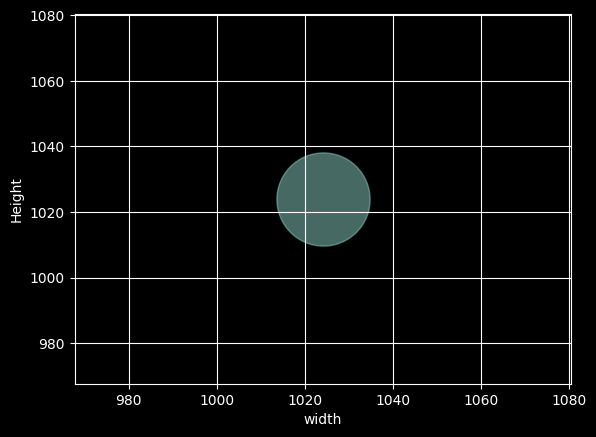

In [26]:
Dict = {}
for images in [train_images , test_images , val_images]:
    for image in images:
        im_shape = image.shape[:2]
        if(im_shape not in Dict.keys()):
            Dict[im_shape]=0
        Dict[im_shape] +=1

arr = np.array(list (Dict.keys())) 
num = np.array(list(Dict.values()))

plt.scatter(arr[:,1],arr[:,0] , s=num *100 ,alpha=0.5)
plt.ylabel('Height')
plt.xlabel('width')
plt.grid()
plt.show()

In [27]:
Dict 

{(1024, 1024): 45}

In [28]:
factor = 32
im_h =  1024
im_w = 1024

desired_shape = ( int(( im_h//factor )* factor) , int((im_w//factor) *factor) )
# desired_shape = (512,512)
config['dataset']['_image_shape'] = desired_shape

def  resize_images_to_numpy(Data ):
    List = []
    for image in tqdm(Data):
        # print(image.dtype)
        new_image = np.array(Image.fromarray(image).resize((desired_shape[1],desired_shape[0])))
        List.append(new_image)
        
    return np.array(List , dtype = np.float32)
    
def  resize_masks_to_numpy(Data):
    List = []
    for mask in tqdm(Data): ## implies RGB
        new_mask = Image.fromarray(mask).resize((desired_shape[1],desired_shape[0]))
        if( np.array(new_mask).ndim == 3):
            new_mask = np.arranp.sum(new_mask , axis=-1,keepdims=True)
        else: ## Implies  Graysclae
            new_mask = np.expand_dims(new_mask, axis = -1)
        
        new_mask = np.where(new_mask > 0 ,1 ,0)
    
        List.append(new_mask)
    return np.array(List , dtype = np.float32)

train_images = resize_images_to_numpy(train_images )
train_masks  = resize_masks_to_numpy(train_masks )

test_images = resize_images_to_numpy(test_images )
test_masks  = resize_masks_to_numpy(test_masks )

val_images = resize_images_to_numpy(val_images )
val_masks  = resize_masks_to_numpy(val_masks )

100%|██████████| 5/5 [00:00<00:00, 372.59it/s]


## > Preprocessing (only form images) & Datasplit

In [29]:
def image_01float_to_unit8(image_float):
    return (image_float*255).astype(np.uint8)
    
def image_clahe_gray(image , clipLimit  = 10 , tileGridLen = 10):
    clahe = cv2.createCLAHE(clipLimit=clipLimit , tileGridSize= (tileGridLen,tileGridLen) )
    # print(np.shape(image))
    # print(np.max(image) , np.array(image).dtype)
    clahe_image = clahe.apply(image)
    
    return clahe_image
# //---------------------------------------------------------------------------------------------------------------
def morphological_operations(image, kernel_size = 15,channel = 1):
    # Convert RGB image to grayscale
    # grayscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    if( np.ndim(image)==3):
        grayscale_image = image[...,channel]
    else :
        grayscale_image = image
        # grayscale_image_cl = image_clahe_gray(grayscale_image,4,16)
    # Apply morphological operations (Top-hat filtering)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    tophat_result = cv2.morphologyEx(grayscale_image, cv2.MORPH_TOPHAT, kernel)
    return tophat_result
    
# Apply gamma correction-----------------------------------------------------------------------------------
def image_gamma_corr( image , gamma = 1.5): ## Uint8 .
    std_image = image_standarize(image)
    
    corrected_image = np.power(std_image , 1/gamma)
    # Convert back to uint8 format
    corrected_image_uint8 = (corrected_image * 255).astype(np.uint8)
    return corrected_image_uint8
# ///-----------------------------------------------------------------------------------------------------------------
from skimage.filters import frangi

def frangi_vessel_enhancement(image , alpha = 0.5 ,beta=0.5, gamma=1 ,kernel_size = 5,channel = 1):
    # Convert RGB image to grayscale
    if(np.ndim(image) == 3):
        # grayscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
        grayscale_image = image[...,channel]
    else :
        grayscale_image = image
    # Apply Frangi filter
    frangi_result = frangi(grayscale_image ,alpha = alpha ,beta=beta ,gamma = gamma ,) 
    frangi_result =  image_01float_to_unit8(frangi_result)
    # frangi_result = frangi(grayscale_image.
    blurred = cv2.GaussianBlur(frangi_result  , (kernel_size , kernel_size ), 0)  # Kernel size (5, 5), sigma = 0
    return blurred 
# ///-----------------------------------------------------------------------------------------------------------------
def image_normalise(image):  # for any type of images 
    mean = np.mean(image, axis=(0, 1))
    std_dev = np.std(image, axis=(0, 1))
# Normalize image
    normalised_image = (image - mean) / std_dev
    return normalised_image
    
def clip_image(image , clip_range =[0,2]): # for any type of images
    normalised_image = image_normalise(image)
    clip_image = np.clip( normalised_image, *clip_range)
    clip_std_image = (clip_image - clip_range[0] )/ (clip_range[1]-clip_range[0])
    clip_image = image_01float_to_unit8(clip_std_image)
    return clip_image

# //--------------------------------------------------------------------------------------------------
def  image_standarize(image_float): ## for all type of image
    # Calculate mean and standard deviation for each channel
    min_ = np.min(image_float, axis=(0, 1))
    max_ = np.max(image_float, axis=(0, 1))
    # Normalize image
    standarized_image = (image_float - min_) / (max_ - min_)
    return standarized_image 

In [30]:
num = 4
func_Dict ={
    'clahe' :image_clahe_gray,
    'gamma_correction':image_gamma_corr,
    'morphological_operations':morphological_operations,
#     'frangi_vessel_enhancement' : frangi_vessel_enhancement,
    'norm_clip': clip_image,
}

param_Dict = {
    'clahe' : {
        'clipLimit' : np.linspace(4,16,num).astype('int'),
        'tileGridLen' : np.random.randint(16,32,(num,),)
   },
    
     'gamma_correction':{
        'gamma' :np.linspace(0.5,0.8,num),
    },
    
     'morphological_operations':{
        'kernel_size' :np.linspace(100,200,num).astype('int'),
    },
#      'frangi_vessel_enhancement':{
#         'kernel_size': 2* np.random.randint(0,2,(num,))+1,
#         'gamma':np.random.uniform(0.5,2.5,(num,))
#     },
    'norm_clip':{
        'clip_range':np.array([[0,2],[0,2.5] ,[0,3],[0.25,2.25],[-0.25,2]])
    },
}
pprint(param_Dict)

{'clahe': {'clipLimit': array([ 4,  8, 12, 16]),
           'tileGridLen': array([24, 27, 17, 19])},
 'gamma_correction': {'gamma': array([0.5, 0.6, 0.7, 0.8])},
 'morphological_operations': {'kernel_size': array([100, 133, 166, 200])},
 'norm_clip': {'clip_range': array([[ 0.  ,  2.  ],
       [ 0.  ,  2.5 ],
       [ 0.  ,  3.  ],
       [ 0.25,  2.25],
       [-0.25,  2.  ]])}}


In [31]:
theta = 100
def concat_aug(image):
    image_List = []
    
    image = np.array(image,dtype=np.uint8)
    image_List.append(image[...,0])
    image_List.append(image[...,1])
    image_List.append(image[...,2])
    image_green = image[...,1]
    
    image_roi = np.where(np.max(image,axis =-1) > theta ,1,0)
#     display_image(image_roi)
    
    for op_name , func in func_Dict.items():
        
        for j in range(num):
            Dict = {}
            for param , vals in param_Dict[op_name].items():
                Dict[param] = vals[j]
                
        ##  will focus on green pixel only 
            img = func(image_green,**Dict)
            # print( op_name , np.max(img),np.shape(img))
            image_List.append(img*image_roi)
            
    image_array = np.moveaxis(image_List ,0, -1)
    return image_array
    
def Augment_train(X):
    X_new = []
    for image in tqdm(X):
        new_image_set = concat_aug(image)        
        X_new.append(new_image_set)
    return np.array(X_new , dtype = 'uint8')

In [32]:
%time train_images = Augment_train(train_images)
%time test_images = Augment_train(test_images)
%time val_images = Augment_train(val_images)

100%|██████████| 31/31 [01:39<00:00,  3.21s/it]


CPU times: user 1min 41s, sys: 1.46 s, total: 1min 42s
Wall time: 1min 41s


100%|██████████| 9/9 [00:28<00:00,  3.18s/it]


CPU times: user 29.2 s, sys: 336 ms, total: 29.5 s
Wall time: 29.1 s


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


CPU times: user 16.2 s, sys: 113 ms, total: 16.4 s
Wall time: 16.1 s


In [33]:
 train_images.shape ,test_images.shape , val_images.shape

((31, 1024, 1024, 19), (9, 1024, 1024, 19), (5, 1024, 1024, 19))

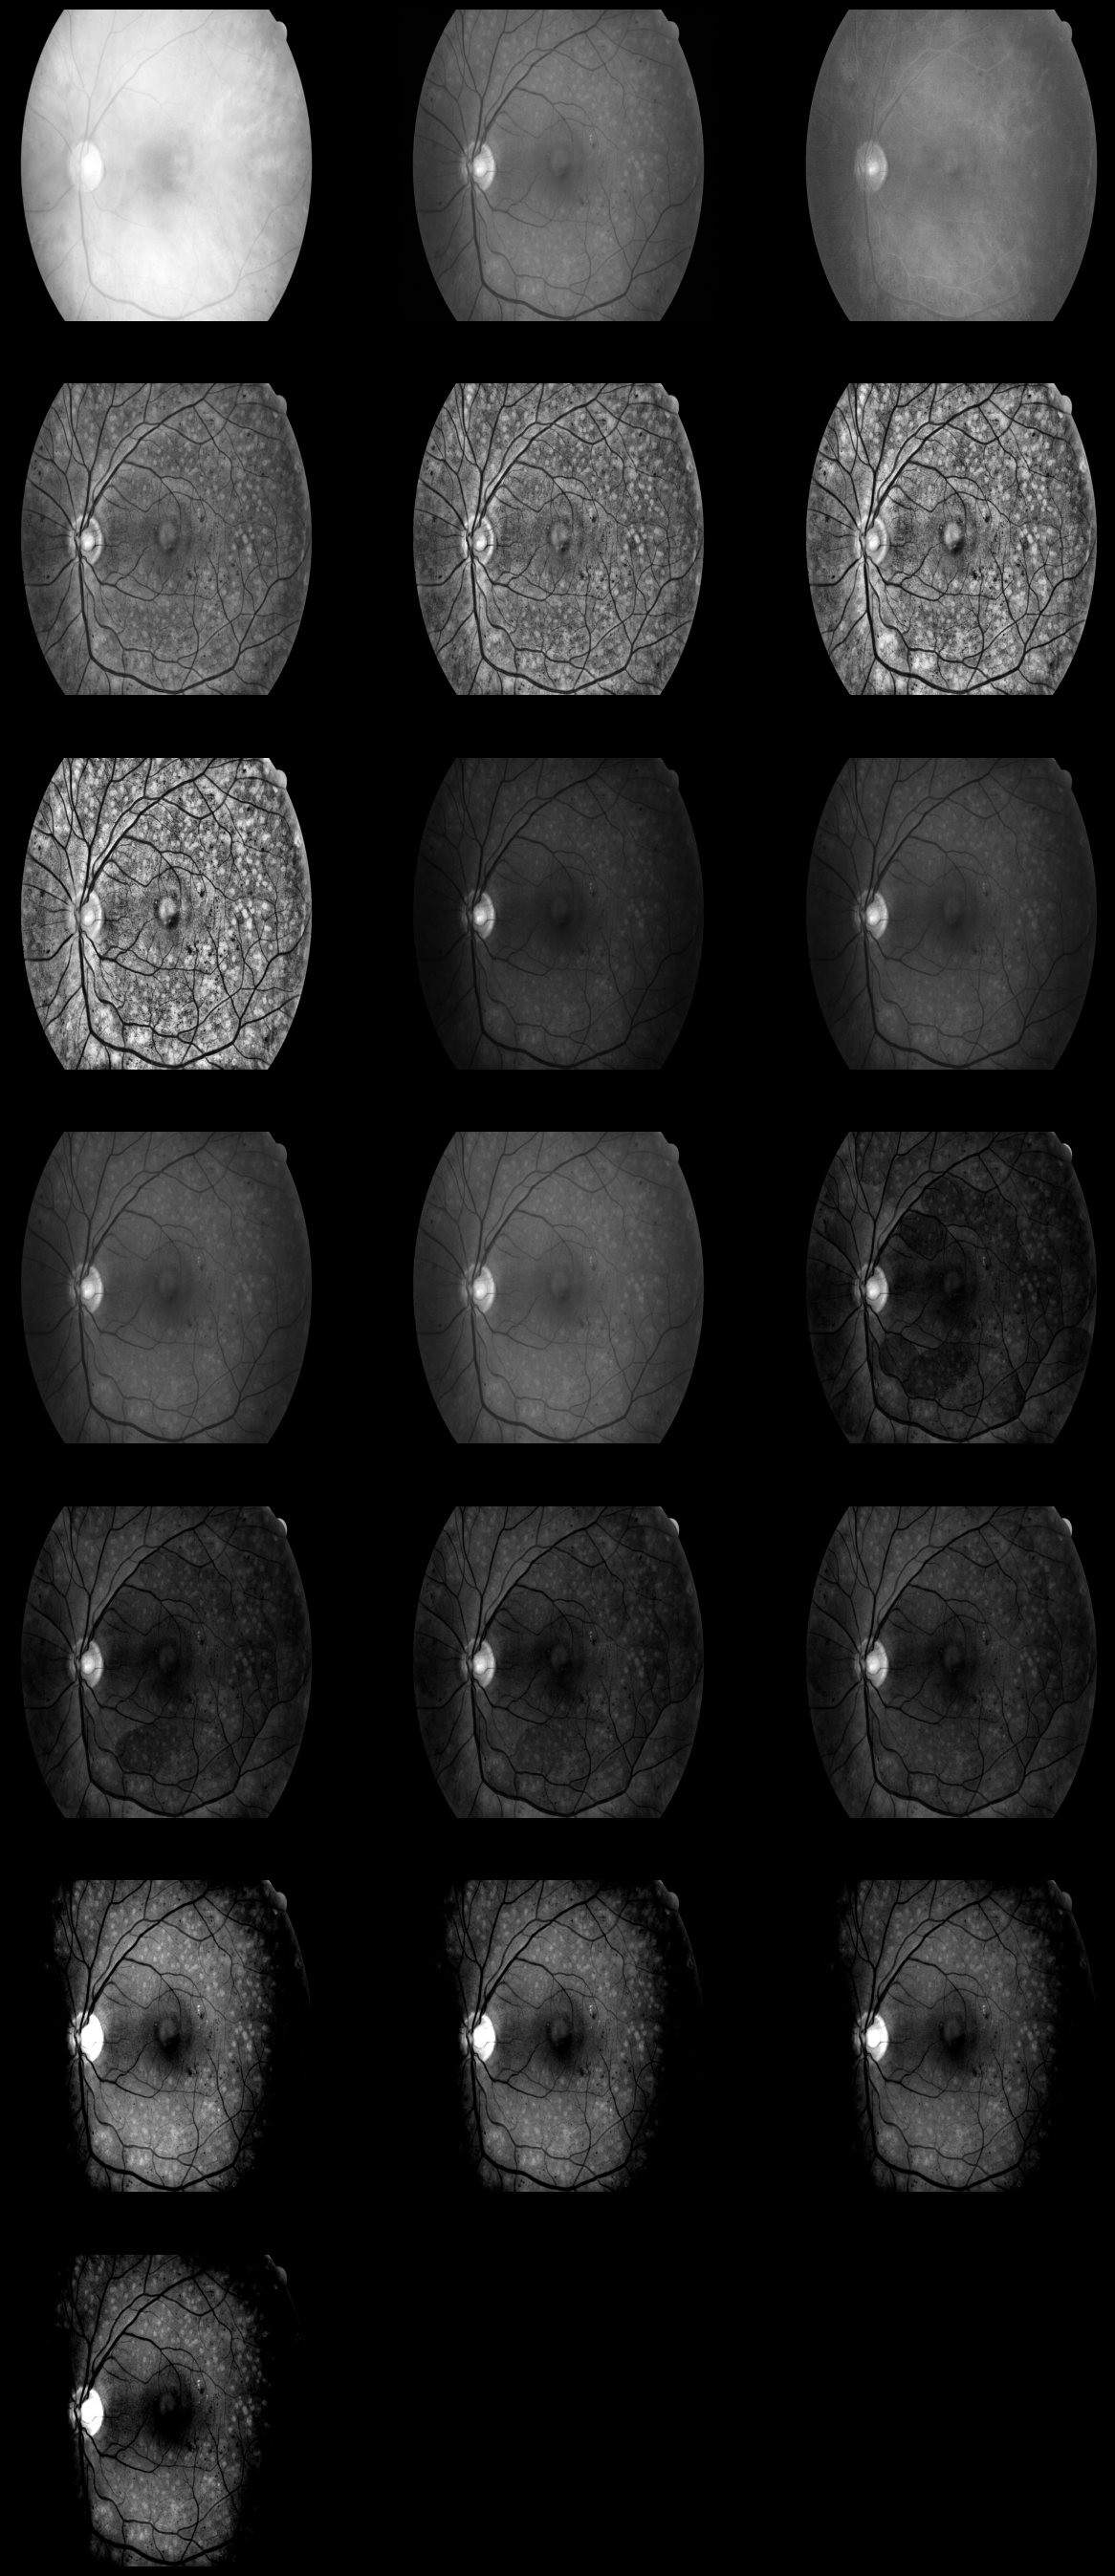

In [34]:
List = []
index = 0
num = 19
for i in range(num):
    List.append(val_images[index][...,i])

display_images(List,cmap = 'gray',size = 5,grid=(10,3))

## > Model Building & importing

### > get the base Models

In [37]:
# !pip install segmentation_models

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

In [38]:
# !pip install keras_unet_collection

In [39]:
# from keras_unet_collection import models as unet_models
# from keras_unet_collection import losses as unet_losses

In [40]:
config['dataset']['_image_shape'] = desired_shape

In [41]:
# num = 0
# model_name = Model_names[0]
# # backbone_name ='EfficientNetB0'
# # backbone_name ='efficientnetb0'

# image_shape =  config['dataset']['_image_shape'] 

In [43]:
import sys

sys.path.append(base_path + "my-liberary/MyKerasLiberary") 

import unet_models as unet_models

In [46]:
num = 0
model_name = Model_names[num]
image_shape =  config['dataset']['_image_shape'] 
n_channel = train_images[0].shape[-1]


unet_models.General_Config['image_shape']= image_shape
unet_models.General_Config['n_channel']= n_channel
unet_models.Model_Config['n_level'] = 4
unet_models.Model_Config['n_unit'] = 32
unet_models.Model_Config['dilation'] = 1
Model = unet_models.BuildUnet(num = num)

In [45]:
# model_name = Model_names[4]
# image_shape =  config['dataset']['_image_shape'] 
# n_channel = train_images[0].shape[-1]


# unet_models.General_Config['image_shape']= image_shape
# unet_models.General_Config['n_channel']= n_channel
# unet_models.Model_Config['n_level'] = 4
# unet_models.Model_Config['n_unit'] = 32
# unet_models.Model_Config['dilation'] = 1

# Model = unet_models.BuildUnet(num = 0 , has_attention=True)

In [47]:
models.clone_model(Model)

<Functional name=Unet_Model, built=True>

In [48]:
Model.summary()

Model: "Unet_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 19)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 1024,      │        640 │ input_layer_1[0]… │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 1024,      │      9,248 │ conv2d_40[0][0]   │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │        128 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 1024,      │          0 │ batch_normalizat… │
│ (Activation)        │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 1024,      │      9,248 │ activation_31[0]… │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │        128 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 1024,      │          0 │ batch_normalizat… │
│ (Activation)        │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 512, 512,  │          0 │ activation_32[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 512, 512,  │      2,112 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 512, 512,  │     36,928 │ conv2d_43[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_44[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 512, 512,  │     36,928 │ activation_33[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 256, 256,  │          0 │ activation_34[0]

 Total params: 8,304,321 (31.68 MB)

 Trainable params: 8,298,433 (31.66 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
# def get_segmentation_model_0():
#     n_class = 1
#     BaseModel = sm.Unet(backbone_name = backbone_name , 
#                                     input_shape = image_shape+(3,),
#                                     encoder_weights='imagenet',
#                                      classes=1,
#                                     activation = 'sigmoid',
#                                     encoder_freeze = True,
#                                     decoder_block_type ='upsampling',
#                                    )
#     return BaseModel
# def get_segmentation_model_1():
#     Model = unet_models.unet_2d(image_shape+(3,) ,
#                             n_labels = 1,
#                             filter_num=[32,64,128,256,512],
#                             output_activation='Sigmoid',
#                             weights='imagenet',
#                             # name = 'my_unet',
#                             batch_norm=True,
#                             backbone=backbone_name,
#                             freeze_backbone=True,
#               )
#     return Model
# def get_segmentation_model_2():
#     Model = unet_models.r2_unet_2d(image_shape + (3,),
#                                n_labels = 1,
#                                 filter_num=[32,64,128,256,512],
#                                output_activation='Sigmoid',
#                                # weights='imagenet',
#                                 # name = 'my_unet',
#                                batch_norm=True,
#                                 # backbone='bacbackbone_name,
#                             # freeze_backbone=True,
#               )
#     return Model
# def get_segmentation_model_3():
#     Model = unet_models.att_unet_2d(image_shape+(3,) ,
#                                n_labels = 1,
#                                filter_num=[32,64,128,256,512],
#                                output_activation='Sigmoid',
#                                # weights='imagenet',
#                                # name = 'my_unet',
#                                batch_norm=True,
            
#                                 # backbone = backbone_name,
#                             # freeze_backbone=True,
#               )
#     return Model
# def get_segmentation_model_4():
#     Model = unet_models.unet_3plus_2d(
#                                 image_shape+(3,) ,
#                                 n_labels = 1,

#                                 filter_num_down=[32,64,128,256,512],
#                                 # filter_num_up=[32,64,128,256,512],
#                                output_activation='Sigmoid',
#                                backbone='EfficientNetB0',
#                                weights='imagenet',
#                                 batch_norm=True,
#                                 # name = 'my_unet',
#                                 freeze_backbone=True,
#                                 filter_num_skip = [64,]*4,
#               )
#     return Model

### > build Model 

In [ ]:
# sm.get_preprocessing(backbone_name)(image)

In [ ]:
# Model = get_segmentation_model_0()
# Model.summary(100)

In [ ]:
# n_unit = 8
# dilation = 2 
# n_channel = 18 
# fn_input = layers.Input(shape = image_shape + (n_channel,))
# x_rescale = layers.Rescaling(1/255.)(fn_input)

# x1 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)
# x2 = layers.Conv2D(n_unit,kernel_size  = 2 ,strides=1,dilation_rate = dilation, padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)
# x3 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,dilation_rate = dilation ,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)
# # x3  = layers.Conv2D(1,kernel_size  = 5 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input
# x_add = layers.Add()([x1,x2,x3]) 
# x_add = layers.BatchNormalization()(x_add)

# x4 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_add)
# x5 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)

# x_add = layers.Add()([x4,x5]) 
# x_add = layers.BatchNormalization()(x_add)

# x6 = layers.Conv2D(4,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(x_add)
# x_add = layers.BatchNormalization()(x_add)

# fn_output = layers.Conv2D(1,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'sigmoid')(x6)

# # fn_output  = Model(x1)
# pre_Model = models.Model(inputs = fn_input , outputs =fn_output,name = 'model_base')

# pre_Model.summary(100)
# models.clone_model(pre_Model)

In [ ]:
# n_unit = 8
# dilation = 2 
# n_channel = 18 
# fn_input = layers.Input(shape = image_shape + (n_channel ,))

# x1 = layers.Conv2D(n_unit, kernel_size  = 1 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input)
# x2 = layers.Conv2D(n_unit,kernel_size  = 2 ,strides=1,dilation_rate = dilation ,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input)
# x3  = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,dilation_rate = dilation ,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input)
# x_add = layers.Add()([x1,x2,x3]) 
# x4 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(x_add)

# x_out = un_model_1(fn_input)
# x_conc =  layers.Concatenate()([x_out*255 , x_add])

# x6 = layers.Conv2D(4,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(x_conc)
# x6 = layers.Conv2D(3,kernel_size  = 3 ,strides=1,padding= 'same',dilation_rate = dilation ,kernel_initializer= 'ones',activation = 'relu')(x6)

# # fn_output  = Model(x1)
# prev_Model = models.Model(inputs = fn_input , outputs = x6,name = 'model_base')

# prev_Model.summary(100)
# models.clone_model(prev_Model)

In [ ]:
# n_unit = 8
# dilation = 2 
# n_channel = 13 
# fn_input = layers.Input(shape = image_shape + (n_channel,))
# # x_rescale = layers.Rescaling(1/255.)(fn_input)
# x_rescale = fn_input

# x1 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',activation = 'tanh')(x_rescale)
# x2 = layers.Conv2D(n_unit,kernel_size  = 2 ,strides=1,dilation_rate = dilation, padding= 'same',activation = 'tanh')(x_rescale)
# x3 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,dilation_rate = dilation ,padding= 'same',activation = 'tanh')(x_rescale)
# # x3  = layers.Conv2D(1,kernel_size  = 5 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input
# x_add = layers.Add()([x1,x2,x3]) 
# # x_add = layers.BatchNormalization()(x_add)

# x4 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,padding= 'same',activation = 'relu')(x_add)
# x5 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',activation = 'relu')(x_rescale)

# x_add = layers.Add()([x4,x5]) 
# # x_add = layers.BatchNormalization()(x_add)

# x6 = layers.Conv2D(4,kernel_size  = 3 ,strides=1,padding= 'same',activation = 'relu')(x_add)
# # x6 = layers.BatchNormalization()(x6)

# fn_output = layers.Conv2D(3,kernel_size  = 3 ,strides=1,padding= 'same')(x6)

# # fn_output  = Model(x1)
# prev_Model = models.Model(inputs = fn_input , outputs =fn_output,name = 'model_base')

# prev_Model.summary(100)
# models.clone_model(prev_Model)

In [ ]:
# un_model_1 = pre_Model
# un_model_1.set_weights(Unet_Model.get_weights())

In [ ]:
# un_model_2 = pre_Model
# un_model_2.set_weights(un_model_1.get_weights())

In [ ]:
# Unet_Model = models.Sequential([prev_Model,Model])
# Unet_Model.summary()
# models.clone_model(Unet_Model)

In [ ]:
# Unet_Model = pre_Model
# Unet_Model = Model

In [ ]:
# Unet_Model(np.zeros(shape = (1,)+image_shape+ (28,))).shape

## > Model Training 

In [49]:
model_weights_path1 = 'unet_model_best1.weights.h5'
model_weights_path2 = 'unet_model_best2.weights.h5'
model_weights_path3 = 'unet_model_best3.weights.h5'
model_weights_path4 = 'unet_model_best4.weights.h5'
model_weights_path5 = 'unet_model_best5.weights.h5'
model_weights_path6 = 'unet_model_best6.weights.h5'


checkpoint_callback = callbacks.ModelCheckpoint(  ## To save Best Models
    model_weights_path1,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True, ## will save best weights. 
    save_weights_only = True, ## If false will save whole model .. .
    mode = 'auto', # if monitor val_loss that it will be min else if val_accuracy that it will be Max..
    save_freq = 'epoch', ## we will do this after every epoch .
)

plateau_callback = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.6, ## reduce by this factor . ## lr = lr*0.1
    patience = 5, ## wait till these number of epochs ,
    verbose = 1,
    mode = 'auto', ## similar to what studied above,,i..e Min or Max..
    min_delta = 0.0, ## if change is less than delta than we will consider it as no improvement . 
    cooldown = 0,  ## to wait after we have updated our lr ,,
    min_lr = 0, ## dont go below this lr.
)

In [50]:
# os.removedirs(base_path + 'liberary')

In [51]:
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.BinaryFocalLoss()
# bce_loss = sm.losses.BinaryCELoss()
# jaccard_loss = sm.losses.JaccardLoss()
# hybrid_loss1 = dice_loss + 1.*(focal_loss)
# hybrid_loss2 = dice_loss + 1.*(bce_loss) + 1.*jaccard_loss
# hybrid_loss3 = jaccard_loss + bce_loss
# # loss = dice_loss
# # loss = hybrid_loss1
# # loss = bce_loss
# # loss = focal_loss
loss = sm.losses.JaccardLoss()
# # loss = sm.losses.binary_focal_jaccard_loss
# # loss = hybrid_loss3

In [52]:
def specificity(y_true, y_pred):
    tn = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * (1 - y_pred), 'float32'))
    total_background = tf.keras.backend.sum(1 - y_true)
    return tn / (total_background + tf.keras.backend.epsilon())

def sensitivity(y_true, y_pred):
    tp = tf.keras.backend.sum(tf.keras.backend.cast(y_true * y_pred, 'float32'))
    total_foreground = tf.keras.backend.sum(y_true)
    return tp / (total_foreground + tf.keras.backend.epsilon())

# Assuming y_true and y_pred are segmentation masks with values in {0, 1} for background and foreground, respectively
# Compute specificity and sensitivity
# spec = specificity(y_true, y_pred)
# sens = sensitivity(y_true, y_pred)

In [53]:
metrics_ = [
            # metrics.MeanIoU(num_classes=2 , name = 'mean_iou_score') ,
            sm.metrics.IOUScore(name = 'iou_score',),
            'accuracy', 
            sm.metrics.FScore(name = 'f1score'),
            metrics.AUC(name = 'auc',),
            # metrics.BinaryIoU(name='binary_iou'),
            specificity,
            sensitivity
           ]

lr = 0.005
Model.compile(
    optimizer = optimizers.Adam(learning_rate=lr),
    loss = loss,
    metrics = metrics_,
)

In [54]:
History = {}
def add_to_history(history):
    for metric,values  in history.history.items():
        if(metric not in History.keys()):
            History[metric] = []
        History[metric] += values

### Augmentatiion

In [55]:
transform = A.Compose(
    [
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5),
    ]
)

def Augment_it(X_train ,Y_train,rescale = False):
    Image_List = []
    Mask_List = []
    for image , mask  in zip(X_train,Y_train):
        Dict = { 'image':image,
                        'mask':mask ,}
        trans_data = transform(**Dict)
        
        Image_List.append(trans_data['image'])
        Mask_List.append(trans_data['mask'])
    
    Image_List = np.array(Image_List)         
    Mask_List = np.array(Mask_List)         
    
    if(rescale):
        Image_List/=255.
    return Image_List,Mask_List

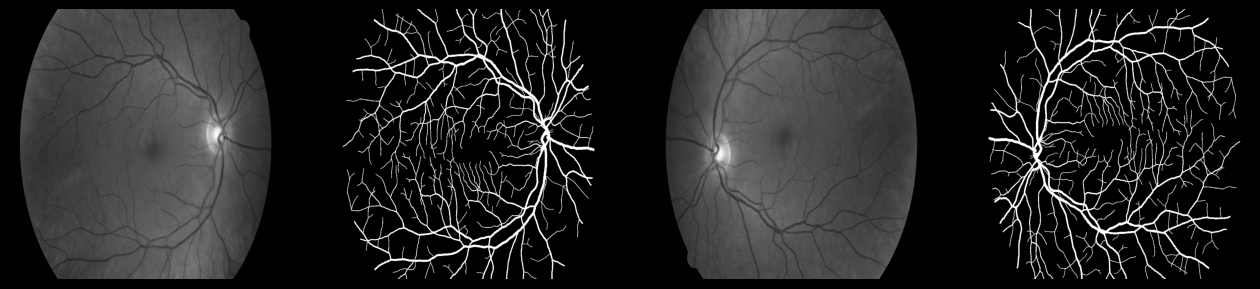

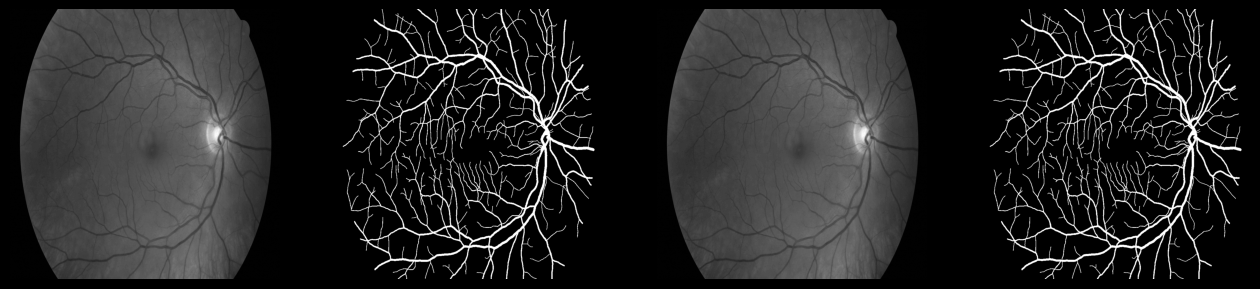

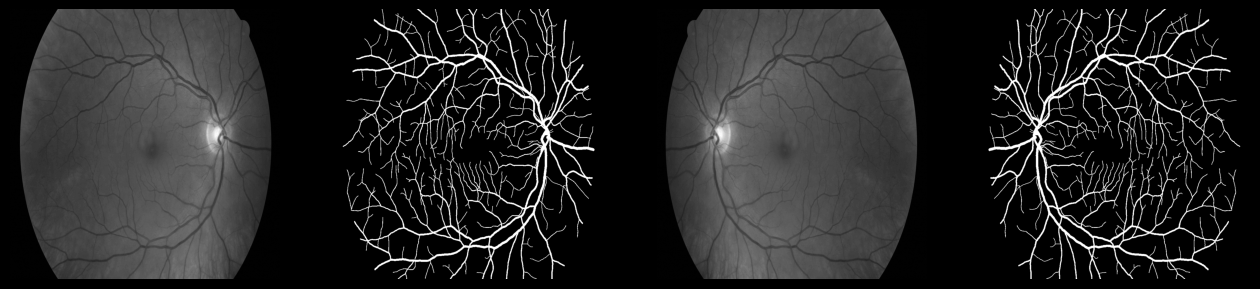

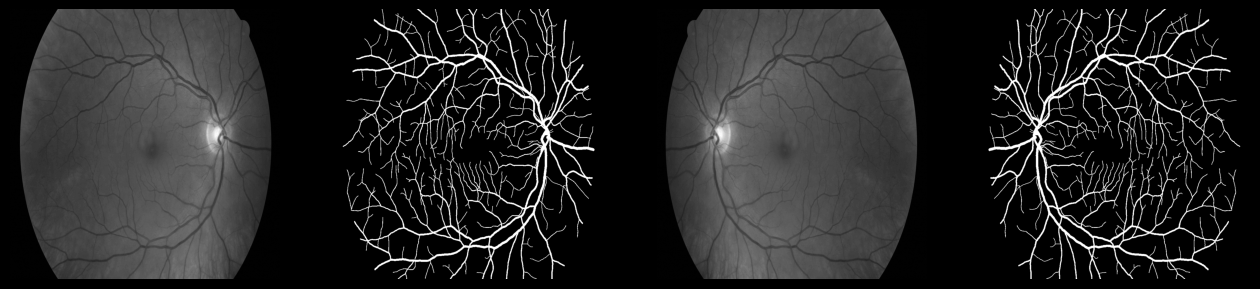

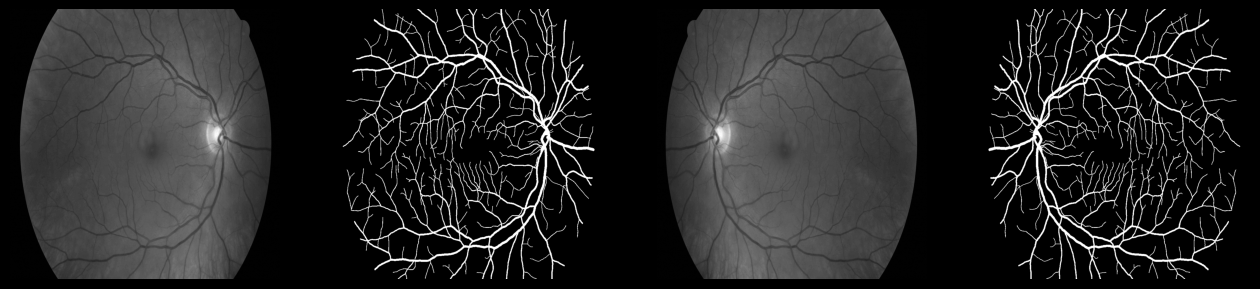

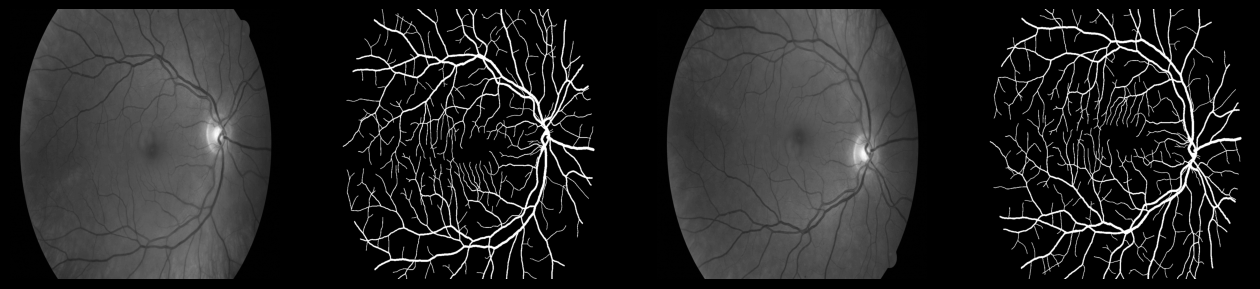

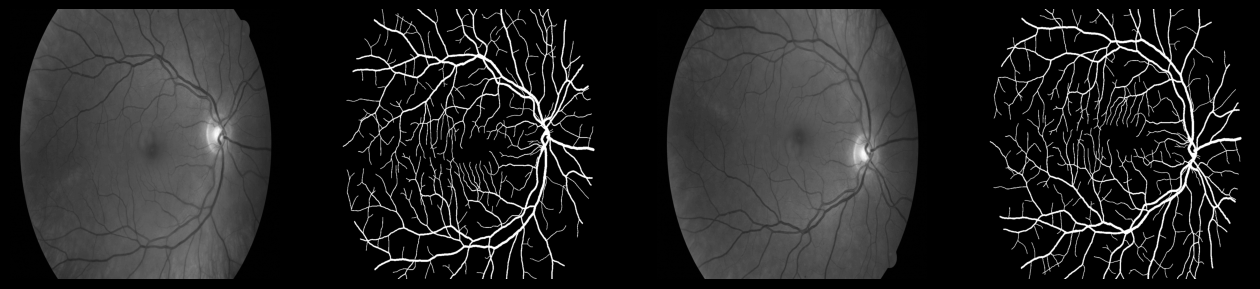

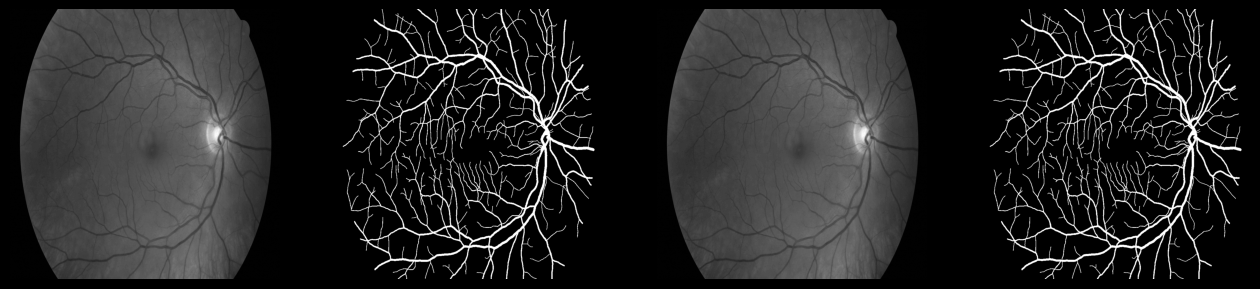

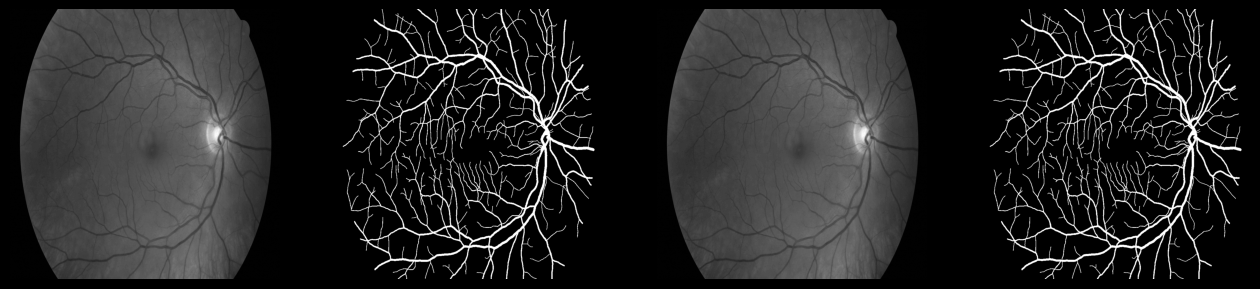

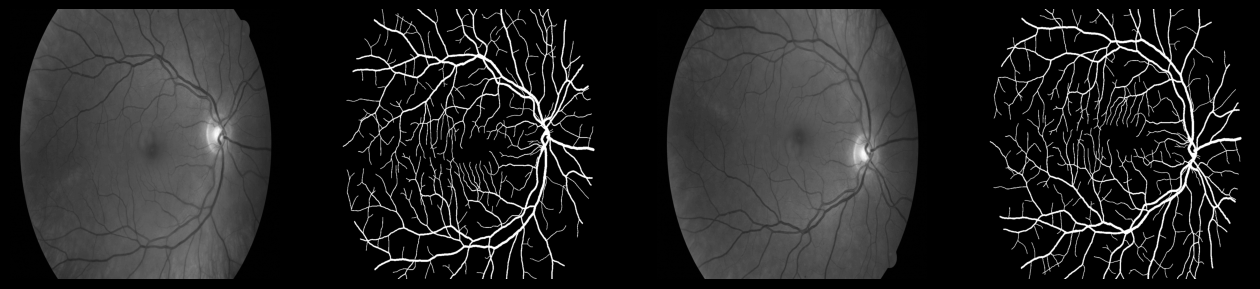

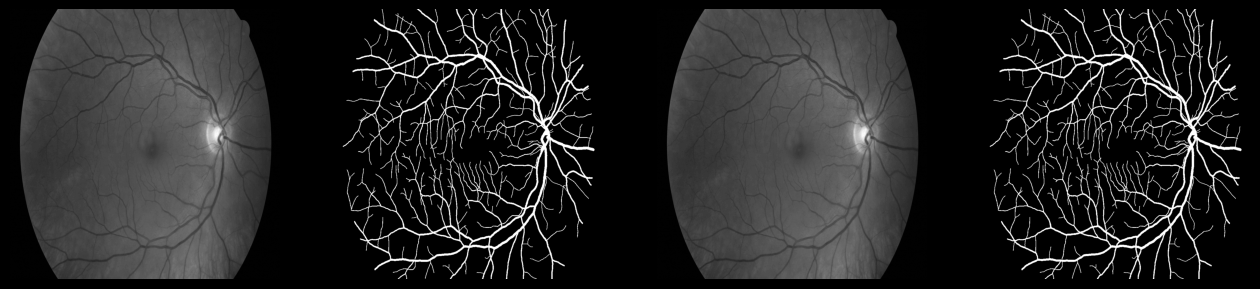

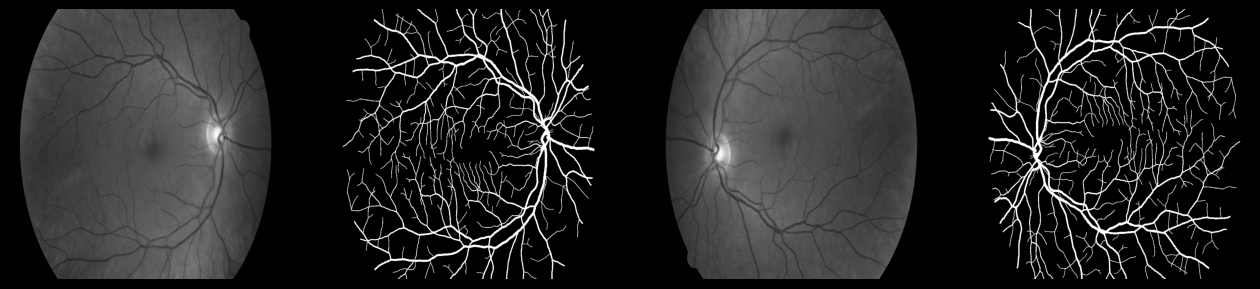

In [56]:
num_ = 12
index = 1
for i in range(num_):
    X_train,Y_train =Augment_it(train_images[:1],train_masks[:1])
    display_images([train_images[0][...,index],train_masks[0] ,X_train[0][...,index],Y_train[0]] ,size = 4,cmap = 'gray')

### Training

In [57]:
batch_size = 2

# back_bone_name =  'efficientnetb0' 
# preprocess = sm.get_preprocessing(back_bone_name)

indexes = np.arange(train_images.shape[0])
patience = 5
temp_wait = 0
factor = 0.5
lr_scale = 1.2
monitor = 'val_loss'
best_monitor_value = 1234647  

In [58]:
n_epoch = 150

for epoch in tqdm(range(n_epoch)):
    indexes = np.random.permutation(indexes)

    X_train ,Y_train = train_images[indexes] , train_masks[indexes] 
    X_train ,Y_train = Augment_it(X_train ,Y_train )
    
    ## preprocessing .......................................................................................................
    # X_train = preprocess(X_train)
    # X_val = preprocess(val_images)
    
    ## Plateau Callback .....................................................................................................
    if(monitor in History.keys()) :
        # print(temp_wait ,History[monitor][-1] , best_monitor_value)
        if (History[monitor][-1] < best_monitor_value):
            best_monitor_value = History[monitor] [-1]
            temp_wait = patience
        else:
            if(temp_wait > 0):
                temp_wait -= 1
            else:
                prev_lr =np.array(Model.optimizer.learning_rate)
                new_lr = (prev_lr) * factor
                setattr(Model.optimizer, 'learning_rate',new_lr)
                print(f">>>>>>>> | Changing Learning Rate from {prev_lr} to {new_lr}")
                
                patience = int(patience * lr_scale)
                temp_wait = patience
    print('>>>>>>>> | Learning is :', np.array(Model.optimizer.learning_rate),"| Patience is",patience ,'| temp_wait is',temp_wait)
    # ///----------------------------------------------------------------------------------------
    history = Model.fit(
                X_train,
                Y_train,
                
                validation_data=[val_images ,val_masks],
                epochs  = 1,
                batch_size = batch_size,
                callbacks=([checkpoint_callback , 
#                             plateau_callback,
                           ]
                        ),
                shuffle = False,
        
                )
    add_to_history(history)

  0%|          | 0/150 [00:00<?, ?it/s]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 0


2024-05-08 02:14:17.391562: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,1024,1024]{3,2,1,0}, f32[2,32,1024,1024]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-08 02:14:18.000824: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.609433156s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,1024,1024]{3,2,1,0}, f32[2,32,1024,1024]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-08 02:14:20.012312: E exter

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6856 - auc: 0.8029 - f1score: 0.3481 - iou_score: 0.2199 - loss: 0.7805 - sensitivity: 0.7431 - specificity: 0.6228   
Epoch 1: val_loss improved from inf to 0.99949, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.6929 - auc: 0.8066 - f1score: 0.3559 - iou_score: 0.2265 - loss: 0.7744 - sensitivity: 0.7446 - specificity: 0.6311 - val_accuracy: 0.9012 - val_auc: 0.4987 - val_f1score: 0.0010 - val_iou_score: 5.1745e-04 - val_loss: 0.9995 - val_sensitivity: 5.3318e-04 - val_specificity: 0.9968


  1%|          | 1/150 [02:16<5:37:48, 136.03s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9333 - auc: 0.8982 - f1score: 0.6983 - iou_score: 0.5387 - loss: 0.4613 - sensitivity: 0.7032 - specificity: 0.9596
Epoch 1: val_loss improved from 0.99949 to 0.90403, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 783ms/step - accuracy: 0.9333 - auc: 0.8982 - f1score: 0.6989 - iou_score: 0.5394 - loss: 0.4607 - sensitivity: 0.7042 - specificity: 0.9597 - val_accuracy: 0.0960 - val_auc: 0.5000 - val_f1score: 0.1750 - val_iou_score: 0.0960 - val_loss: 0.9040 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00


  1%|▏         | 2/150 [02:31<2:40:40, 65.14s/it] 

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.9417 - auc: 0.8824 - f1score: 0.7317 - iou_score: 0.5784 - loss: 0.4214 - sensitivity: 0.7085 - specificity: 0.9708
Epoch 1: val_loss did not improve from 0.90403
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 767ms/step - accuracy: 0.9416 - auc: 0.8827 - f1score: 0.7315 - iou_score: 0.5782 - loss: 0.4214 - sensitivity: 0.7096 - specificity: 0.9705 - val_accuracy: 0.0960 - val_auc: 0.5000 - val_f1score: 0.1750 - val_iou_score: 0.0960 - val_loss: 0.9040 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00


  2%|▏         | 3/150 [02:46<1:43:36, 42.29s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.9425 - auc: 0.8760 - f1score: 0.7318 - iou_score: 0.5787 - loss: 0.4213 - sensitivity: 0.7087 - specificity: 0.9716
Epoch 1: val_loss did not improve from 0.90403
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9425 - auc: 0.8764 - f1score: 0.7321 - iou_score: 0.5791 - loss: 0.4209 - sensitivity: 0.7098 - specificity: 0.9714 - val_accuracy: 0.8992 - val_auc: 0.4976 - val_f1score: 0.0014 - val_iou_score: 6.9108e-04 - val_loss: 0.9993 - val_sensitivity: 7.2686e-04 - val_specificity: 0.9945


  3%|▎         | 4/150 [03:01<1:16:48, 31.56s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.9480 - auc: 0.8915 - f1score: 0.7668 - iou_score: 0.6227 - loss: 0.3773 - sensitivity: 0.7421 - specificity: 0.9747
Epoch 1: val_loss improved from 0.90403 to 0.89887, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 776ms/step - accuracy: 0.9479 - auc: 0.8914 - f1score: 0.7661 - iou_score: 0.6217 - loss: 0.3781 - sensitivity: 0.7419 - specificity: 0.9746 - val_accuracy: 0.1759 - val_auc: 0.5303 - val_f1score: 0.1821 - val_iou_score: 0.1003 - val_loss: 0.8989 - val_sensitivity: 0.9714 - val_specificity: 0.0769


  3%|▎         | 5/150 [03:17<1:02:11, 25.73s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9468 - auc: 0.8863 - f1score: 0.7533 - iou_score: 0.6053 - loss: 0.3946 - sensitivity: 0.7330 - specificity: 0.9733
Epoch 1: val_loss did not improve from 0.89887
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 749ms/step - accuracy: 0.9468 - auc: 0.8867 - f1score: 0.7538 - iou_score: 0.6059 - loss: 0.3939 - sensitivity: 0.7339 - specificity: 0.9732 - val_accuracy: 0.9040 - val_auc: 0.5000 - val_f1score: 6.6834e-11 - val_iou_score: 6.6834e-11 - val_loss: 1.0000 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000


  4%|▍         | 6/150 [03:31<52:49, 22.01s/it]  

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9497 - auc: 0.8959 - f1score: 0.7731 - iou_score: 0.6309 - loss: 0.3691 - sensitivity: 0.7562 - specificity: 0.9746
Epoch 1: val_loss did not improve from 0.89887
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9497 - auc: 0.8958 - f1score: 0.7730 - iou_score: 0.6308 - loss: 0.3692 - sensitivity: 0.7563 - specificity: 0.9745 - val_accuracy: 0.9040 - val_auc: 0.5000 - val_f1score: 5.8155e-05 - val_iou_score: 2.9079e-05 - val_loss: 1.0000 - val_sensitivity: 2.9095e-05 - val_specificity: 1.0000


  5%|▍         | 7/150 [03:47<47:06, 19.77s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9509 - auc: 0.8950 - f1score: 0.7743 - iou_score: 0.6325 - loss: 0.3676 - sensitivity: 0.7556 - specificity: 0.9757
Epoch 1: val_loss did not improve from 0.89887
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9510 - auc: 0.8951 - f1score: 0.7747 - iou_score: 0.6330 - loss: 0.3672 - sensitivity: 0.7559 - specificity: 0.9757 - val_accuracy: 0.9060 - val_auc: 0.5139 - val_f1score: 0.0606 - val_iou_score: 0.0317 - val_loss: 0.9619 - val_sensitivity: 0.0329 - val_specificity: 0.9974


  5%|▌         | 8/150 [04:02<43:16, 18.29s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9522 - auc: 0.9046 - f1score: 0.7895 - iou_score: 0.6531 - loss: 0.3471 - sensitivity: 0.7817 - specificity: 0.9743
Epoch 1: val_loss improved from 0.89887 to 0.88828, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 782ms/step - accuracy: 0.9522 - auc: 0.9044 - f1score: 0.7893 - iou_score: 0.6528 - loss: 0.3474 - sensitivity: 0.7814 - specificity: 0.9744 - val_accuracy: 0.9035 - val_auc: 0.5522 - val_f1score: 0.1852 - val_iou_score: 0.1032 - val_loss: 0.8883 - val_sensitivity: 0.1198 - val_specificity: 0.9849


  6%|▌         | 9/150 [04:17<40:54, 17.41s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.9519 - auc: 0.9010 - f1score: 0.7809 - iou_score: 0.6415 - loss: 0.3587 - sensitivity: 0.7827 - specificity: 0.9729
Epoch 1: val_loss improved from 0.88828 to 0.52047, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 778ms/step - accuracy: 0.9519 - auc: 0.9009 - f1score: 0.7813 - iou_score: 0.6420 - loss: 0.3584 - sensitivity: 0.7825 - specificity: 0.9730 - val_accuracy: 0.9358 - val_auc: 0.8098 - val_f1score: 0.6267 - val_iou_score: 0.4602 - val_loss: 0.5205 - val_sensitivity: 0.6000 - val_specificity: 0.9667


  7%|▋         | 10/150 [04:33<39:16, 16.83s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.9533 - auc: 0.9067 - f1score: 0.7941 - iou_score: 0.6599 - loss: 0.3399 - sensitivity: 0.7907 - specificity: 0.9742
Epoch 1: val_loss improved from 0.52047 to 0.48719, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 781ms/step - accuracy: 0.9533 - auc: 0.9066 - f1score: 0.7936 - iou_score: 0.6592 - loss: 0.3403 - sensitivity: 0.7905 - specificity: 0.9742 - val_accuracy: 0.9198 - val_auc: 0.8780 - val_f1score: 0.6373 - val_iou_score: 0.4789 - val_loss: 0.4872 - val_sensitivity: 0.7856 - val_specificity: 0.9147


  7%|▋         | 11/150 [04:48<38:04, 16.44s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9534 - auc: 0.8961 - f1score: 0.7898 - iou_score: 0.6536 - loss: 0.3464 - sensitivity: 0.7645 - specificity: 0.9785
Epoch 1: val_loss improved from 0.48719 to 0.48493, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 782ms/step - accuracy: 0.9533 - auc: 0.8962 - f1score: 0.7894 - iou_score: 0.6532 - loss: 0.3468 - sensitivity: 0.7649 - specificity: 0.9783 - val_accuracy: 0.9356 - val_auc: 0.8527 - val_f1score: 0.6648 - val_iou_score: 0.4999 - val_loss: 0.4849 - val_sensitivity: 0.7091 - val_specificity: 0.9543


  8%|▊         | 12/150 [05:04<37:09, 16.15s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9539 - auc: 0.9047 - f1score: 0.7932 - iou_score: 0.6584 - loss: 0.3415 - sensitivity: 0.7838 - specificity: 0.9757
Epoch 1: val_loss improved from 0.48493 to 0.45812, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 783ms/step - accuracy: 0.9539 - auc: 0.9047 - f1score: 0.7933 - iou_score: 0.6585 - loss: 0.3414 - sensitivity: 0.7841 - specificity: 0.9757 - val_accuracy: 0.9317 - val_auc: 0.9028 - val_f1score: 0.6837 - val_iou_score: 0.5237 - val_loss: 0.4581 - val_sensitivity: 0.8300 - val_specificity: 0.9346


  9%|▊         | 13/150 [05:19<36:26, 15.96s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9541 - auc: 0.9017 - f1score: 0.7871 - iou_score: 0.6502 - loss: 0.3497 - sensitivity: 0.7793 - specificity: 0.9756
Epoch 1: val_loss did not improve from 0.45812
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9542 - auc: 0.9019 - f1score: 0.7876 - iou_score: 0.6510 - loss: 0.3488 - sensitivity: 0.7798 - specificity: 0.9756 - val_accuracy: 0.9284 - val_auc: 0.9056 - val_f1score: 0.6800 - val_iou_score: 0.5186 - val_loss: 0.4669 - val_sensitivity: 0.8471 - val_specificity: 0.9306


  9%|▉         | 14/150 [05:35<35:39, 15.73s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9567 - auc: 0.9125 - f1score: 0.8110 - iou_score: 0.6831 - loss: 0.3169 - sensitivity: 0.7997 - specificity: 0.9774
Epoch 1: val_loss improved from 0.45812 to 0.43529, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 779ms/step - accuracy: 0.9567 - auc: 0.9124 - f1score: 0.8106 - iou_score: 0.6826 - loss: 0.3174 - sensitivity: 0.7995 - specificity: 0.9774 - val_accuracy: 0.9389 - val_auc: 0.9050 - val_f1score: 0.7085 - val_iou_score: 0.5514 - val_loss: 0.4353 - val_sensitivity: 0.8291 - val_specificity: 0.9450


 10%|█         | 15/150 [05:50<35:13, 15.66s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9542 - auc: 0.8993 - f1score: 0.7903 - iou_score: 0.6540 - loss: 0.3459 - sensitivity: 0.7754 - specificity: 0.9767
Epoch 1: val_loss did not improve from 0.43529
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 754ms/step - accuracy: 0.9543 - auc: 0.8998 - f1score: 0.7910 - iou_score: 0.6551 - loss: 0.3449 - sensitivity: 0.7764 - specificity: 0.9767 - val_accuracy: 0.7589 - val_auc: 0.8604 - val_f1score: 0.4216 - val_iou_score: 0.2703 - val_loss: 0.7188 - val_sensitivity: 0.9460 - val_specificity: 0.7210


 11%|█         | 16/150 [06:05<34:39, 15.52s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9561 - auc: 0.9099 - f1score: 0.8083 - iou_score: 0.6789 - loss: 0.3210 - sensitivity: 0.7978 - specificity: 0.9768
Epoch 1: val_loss did not improve from 0.43529
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 758ms/step - accuracy: 0.9561 - auc: 0.9100 - f1score: 0.8082 - iou_score: 0.6787 - loss: 0.3210 - sensitivity: 0.7981 - specificity: 0.9768 - val_accuracy: 0.8643 - val_auc: 0.8944 - val_f1score: 0.5490 - val_iou_score: 0.3810 - val_loss: 0.6120 - val_sensitivity: 0.8900 - val_specificity: 0.8558


 11%|█▏        | 17/150 [06:20<34:09, 15.41s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9577 - auc: 0.9069 - f1score: 0.8067 - iou_score: 0.6764 - loss: 0.3236 - sensitivity: 0.7897 - specificity: 0.9789
Epoch 1: val_loss did not improve from 0.43529
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9577 - auc: 0.9071 - f1score: 0.8070 - iou_score: 0.6767 - loss: 0.3233 - sensitivity: 0.7902 - specificity: 0.9789 - val_accuracy: 0.7640 - val_auc: 0.8661 - val_f1score: 0.4390 - val_iou_score: 0.2825 - val_loss: 0.7207 - val_sensitivity: 0.9469 - val_specificity: 0.7486


 12%|█▏        | 18/150 [06:35<33:39, 15.30s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9581 - auc: 0.9121 - f1score: 0.8097 - iou_score: 0.6810 - loss: 0.3191 - sensitivity: 0.8042 - specificity: 0.9775
Epoch 1: val_loss did not improve from 0.43529
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9581 - auc: 0.9122 - f1score: 0.8099 - iou_score: 0.6813 - loss: 0.3188 - sensitivity: 0.8044 - specificity: 0.9775 - val_accuracy: 0.7790 - val_auc: 0.8561 - val_f1score: 0.4912 - val_iou_score: 0.3340 - val_loss: 0.6969 - val_sensitivity: 0.9067 - val_specificity: 0.7891


 13%|█▎        | 19/150 [06:51<33:18, 15.26s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9582 - auc: 0.9159 - f1score: 0.8137 - iou_score: 0.6870 - loss: 0.3132 - sensitivity: 0.8131 - specificity: 0.9767
Epoch 1: val_loss did not improve from 0.43529
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9583 - auc: 0.9158 - f1score: 0.8140 - iou_score: 0.6874 - loss: 0.3130 - sensitivity: 0.8128 - specificity: 0.9768 - val_accuracy: 0.8957 - val_auc: 0.9180 - val_f1score: 0.6118 - val_iou_score: 0.4450 - val_loss: 0.5364 - val_sensitivity: 0.9157 - val_specificity: 0.8818


 13%|█▎        | 20/150 [07:06<32:57, 15.21s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9569 - auc: 0.9216 - f1score: 0.8178 - iou_score: 0.6928 - loss: 0.3071 - sensitivity: 0.8327 - specificity: 0.9731
Epoch 1: val_loss did not improve from 0.43529
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9570 - auc: 0.9215 - f1score: 0.8177 - iou_score: 0.6927 - loss: 0.3071 - sensitivity: 0.8320 - specificity: 0.9733 - val_accuracy: 0.9344 - val_auc: 0.9223 - val_f1score: 0.7134 - val_iou_score: 0.5556 - val_loss: 0.4439 - val_sensitivity: 0.8593 - val_specificity: 0.9424


 14%|█▍        | 21/150 [07:21<32:34, 15.15s/it]

>>>>>>>> | Changing Learning Rate from 0.004999999888241291 to 0.0024999999441206455
>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9591 - auc: 0.9136 - f1score: 0.8176 - iou_score: 0.6922 - loss: 0.3078 - sensitivity: 0.8050 - specificity: 0.9791
Epoch 1: val_loss improved from 0.43529 to 0.37820, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 781ms/step - accuracy: 0.9591 - auc: 0.9138 - f1score: 0.8178 - iou_score: 0.6923 - loss: 0.3075 - sensitivity: 0.8054 - specificity: 0.9791 - val_accuracy: 0.9514 - val_auc: 0.9186 - val_f1score: 0.7604 - val_iou_score: 0.6152 - val_loss: 0.3782 - val_sensitivity: 0.8401 - val_specificity: 0.9613


 15%|█▍        | 22/150 [07:36<32:26, 15.21s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9606 - auc: 0.9179 - f1score: 0.8243 - iou_score: 0.7019 - loss: 0.2979 - sensitivity: 0.8175 - specificity: 0.9789
Epoch 1: val_loss improved from 0.37820 to 0.35766, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 780ms/step - accuracy: 0.9606 - auc: 0.9180 - f1score: 0.8242 - iou_score: 0.7017 - loss: 0.2979 - sensitivity: 0.8176 - specificity: 0.9789 - val_accuracy: 0.9569 - val_auc: 0.9137 - val_f1score: 0.7748 - val_iou_score: 0.6336 - val_loss: 0.3577 - val_sensitivity: 0.8110 - val_specificity: 0.9705


 15%|█▌        | 23/150 [07:51<32:19, 15.27s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9630 - auc: 0.9250 - f1score: 0.8402 - iou_score: 0.7258 - loss: 0.2742 - sensitivity: 0.8279 - specificity: 0.9813
Epoch 1: val_loss improved from 0.35766 to 0.34698, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 782ms/step - accuracy: 0.9628 - auc: 0.9247 - f1score: 0.8393 - iou_score: 0.7244 - loss: 0.2756 - sensitivity: 0.8276 - specificity: 0.9811 - val_accuracy: 0.9608 - val_auc: 0.9046 - val_f1score: 0.7842 - val_iou_score: 0.6461 - val_loss: 0.3470 - val_sensitivity: 0.7742 - val_specificity: 0.9793


 16%|█▌        | 24/150 [08:07<32:12, 15.34s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9597 - auc: 0.9170 - f1score: 0.8232 - iou_score: 0.7003 - loss: 0.2999 - sensitivity: 0.8132 - specificity: 0.9790
Epoch 1: val_loss did not improve from 0.34698
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9598 - auc: 0.9171 - f1score: 0.8234 - iou_score: 0.7007 - loss: 0.2996 - sensitivity: 0.8136 - specificity: 0.9790 - val_accuracy: 0.9595 - val_auc: 0.8985 - val_f1score: 0.7768 - val_iou_score: 0.6365 - val_loss: 0.3550 - val_sensitivity: 0.7756 - val_specificity: 0.9768


 17%|█▋        | 25/150 [08:22<31:50, 15.29s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9628 - auc: 0.9240 - f1score: 0.8352 - iou_score: 0.7178 - loss: 0.2823 - sensitivity: 0.8299 - specificity: 0.9799
Epoch 1: val_loss improved from 0.34698 to 0.34528, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 784ms/step - accuracy: 0.9627 - auc: 0.9239 - f1score: 0.8347 - iou_score: 0.7170 - loss: 0.2830 - sensitivity: 0.8297 - specificity: 0.9798 - val_accuracy: 0.9608 - val_auc: 0.9017 - val_f1score: 0.7855 - val_iou_score: 0.6479 - val_loss: 0.3453 - val_sensitivity: 0.7820 - val_specificity: 0.9782


 17%|█▋        | 26/150 [08:37<31:40, 15.33s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9617 - auc: 0.9195 - f1score: 0.8282 - iou_score: 0.7077 - loss: 0.2925 - sensitivity: 0.8215 - specificity: 0.9795
Epoch 1: val_loss did not improve from 0.34528
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9617 - auc: 0.9194 - f1score: 0.8282 - iou_score: 0.7076 - loss: 0.2927 - sensitivity: 0.8214 - specificity: 0.9795 - val_accuracy: 0.9584 - val_auc: 0.8807 - val_f1score: 0.7639 - val_iou_score: 0.6191 - val_loss: 0.3744 - val_sensitivity: 0.7335 - val_specificity: 0.9804


 18%|█▊        | 27/150 [08:52<31:12, 15.22s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9599 - auc: 0.9236 - f1score: 0.8244 - iou_score: 0.7021 - loss: 0.2980 - sensitivity: 0.8356 - specificity: 0.9758
Epoch 1: val_loss improved from 0.34528 to 0.34506, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 781ms/step - accuracy: 0.9599 - auc: 0.9235 - f1score: 0.8247 - iou_score: 0.7025 - loss: 0.2978 - sensitivity: 0.8354 - specificity: 0.9759 - val_accuracy: 0.9617 - val_auc: 0.8954 - val_f1score: 0.7861 - val_iou_score: 0.6485 - val_loss: 0.3451 - val_sensitivity: 0.7614 - val_specificity: 0.9819


 19%|█▊        | 28/150 [09:08<31:07, 15.31s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9601 - auc: 0.9209 - f1score: 0.8253 - iou_score: 0.7035 - loss: 0.2964 - sensitivity: 0.8260 - specificity: 0.9776
Epoch 1: val_loss did not improve from 0.34506
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9602 - auc: 0.9209 - f1score: 0.8254 - iou_score: 0.7037 - loss: 0.2961 - sensitivity: 0.8260 - specificity: 0.9776 - val_accuracy: 0.9568 - val_auc: 0.8582 - val_f1score: 0.7454 - val_iou_score: 0.5954 - val_loss: 0.4053 - val_sensitivity: 0.6830 - val_specificity: 0.9845


 19%|█▉        | 29/150 [09:23<30:43, 15.23s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9616 - auc: 0.9238 - f1score: 0.8318 - iou_score: 0.7127 - loss: 0.2872 - sensitivity: 0.8337 - specificity: 0.9782
Epoch 1: val_loss did not improve from 0.34506
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9616 - auc: 0.9237 - f1score: 0.8316 - iou_score: 0.7124 - loss: 0.2875 - sensitivity: 0.8335 - specificity: 0.9782 - val_accuracy: 0.9605 - val_auc: 0.8832 - val_f1score: 0.7730 - val_iou_score: 0.6309 - val_loss: 0.3606 - val_sensitivity: 0.7291 - val_specificity: 0.9839


 20%|██        | 30/150 [09:38<30:28, 15.24s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9624 - auc: 0.9245 - f1score: 0.8336 - iou_score: 0.7150 - loss: 0.2849 - sensitivity: 0.8327 - specificity: 0.9789
Epoch 1: val_loss did not improve from 0.34506
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9623 - auc: 0.9242 - f1score: 0.8333 - iou_score: 0.7145 - loss: 0.2851 - sensitivity: 0.8321 - specificity: 0.9789 - val_accuracy: 0.9586 - val_auc: 0.8677 - val_f1score: 0.7581 - val_iou_score: 0.6111 - val_loss: 0.3845 - val_sensitivity: 0.6975 - val_specificity: 0.9852


 21%|██        | 31/150 [09:54<30:12, 15.23s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9617 - auc: 0.9225 - f1score: 0.8294 - iou_score: 0.7091 - loss: 0.2909 - sensitivity: 0.8314 - specificity: 0.9783
Epoch 1: val_loss did not improve from 0.34506
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9617 - auc: 0.9223 - f1score: 0.8293 - iou_score: 0.7090 - loss: 0.2910 - sensitivity: 0.8311 - specificity: 0.9784 - val_accuracy: 0.9599 - val_auc: 0.8795 - val_f1score: 0.7700 - val_iou_score: 0.6271 - val_loss: 0.3666 - val_sensitivity: 0.7311 - val_specificity: 0.9825


 21%|██▏       | 32/150 [10:09<29:53, 15.20s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9609 - auc: 0.9231 - f1score: 0.8242 - iou_score: 0.7021 - loss: 0.2979 - sensitivity: 0.8352 - specificity: 0.9766
Epoch 1: val_loss improved from 0.34506 to 0.33377, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 784ms/step - accuracy: 0.9610 - auc: 0.9231 - f1score: 0.8246 - iou_score: 0.7027 - loss: 0.2974 - sensitivity: 0.8350 - specificity: 0.9767 - val_accuracy: 0.9614 - val_auc: 0.9120 - val_f1score: 0.7937 - val_iou_score: 0.6591 - val_loss: 0.3338 - val_sensitivity: 0.8102 - val_specificity: 0.9759


 22%|██▏       | 33/150 [10:24<29:48, 15.29s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9608 - auc: 0.9222 - f1score: 0.8246 - iou_score: 0.7020 - loss: 0.2979 - sensitivity: 0.8324 - specificity: 0.9770
Epoch 1: val_loss did not improve from 0.33377
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9609 - auc: 0.9222 - f1score: 0.8249 - iou_score: 0.7025 - loss: 0.2974 - sensitivity: 0.8322 - specificity: 0.9771 - val_accuracy: 0.9590 - val_auc: 0.8988 - val_f1score: 0.7764 - val_iou_score: 0.6360 - val_loss: 0.3557 - val_sensitivity: 0.7795 - val_specificity: 0.9761


 23%|██▎       | 34/150 [10:39<29:22, 15.19s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9633 - auc: 0.9273 - f1score: 0.8331 - iou_score: 0.7151 - loss: 0.2848 - sensitivity: 0.8429 - specificity: 0.9782
Epoch 1: val_loss did not improve from 0.33377
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9632 - auc: 0.9271 - f1score: 0.8329 - iou_score: 0.7148 - loss: 0.2850 - sensitivity: 0.8425 - specificity: 0.9782 - val_accuracy: 0.9612 - val_auc: 0.8879 - val_f1score: 0.7823 - val_iou_score: 0.6432 - val_loss: 0.3520 - val_sensitivity: 0.7541 - val_specificity: 0.9819


 23%|██▎       | 35/150 [10:54<29:05, 15.18s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9637 - auc: 0.9235 - f1score: 0.8381 - iou_score: 0.7224 - loss: 0.2777 - sensitivity: 0.8295 - specificity: 0.9809
Epoch 1: val_loss did not improve from 0.33377
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9637 - auc: 0.9234 - f1score: 0.8379 - iou_score: 0.7221 - loss: 0.2781 - sensitivity: 0.8295 - specificity: 0.9809 - val_accuracy: 0.9603 - val_auc: 0.8667 - val_f1score: 0.7670 - val_iou_score: 0.6228 - val_loss: 0.3738 - val_sensitivity: 0.7048 - val_specificity: 0.9862


 24%|██▍       | 36/150 [11:09<28:48, 15.16s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9620 - auc: 0.9226 - f1score: 0.8316 - iou_score: 0.7124 - loss: 0.2877 - sensitivity: 0.8333 - specificity: 0.9785
Epoch 1: val_loss did not improve from 0.33377
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9620 - auc: 0.9227 - f1score: 0.8317 - iou_score: 0.7126 - loss: 0.2876 - sensitivity: 0.8334 - specificity: 0.9785 - val_accuracy: 0.9608 - val_auc: 0.8664 - val_f1score: 0.7698 - val_iou_score: 0.6266 - val_loss: 0.3723 - val_sensitivity: 0.7063 - val_specificity: 0.9867


 25%|██▍       | 37/150 [11:24<28:28, 15.12s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9628 - auc: 0.9232 - f1score: 0.8349 - iou_score: 0.7174 - loss: 0.2825 - sensitivity: 0.8331 - specificity: 0.9795
Epoch 1: val_loss did not improve from 0.33377
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9628 - auc: 0.9232 - f1score: 0.8348 - iou_score: 0.7172 - loss: 0.2827 - sensitivity: 0.8329 - specificity: 0.9795 - val_accuracy: 0.9583 - val_auc: 0.9019 - val_f1score: 0.7739 - val_iou_score: 0.6339 - val_loss: 0.3507 - val_sensitivity: 0.8035 - val_specificity: 0.9703


 25%|██▌       | 38/150 [11:40<28:15, 15.14s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9609 - auc: 0.9221 - f1score: 0.8268 - iou_score: 0.7054 - loss: 0.2946 - sensitivity: 0.8333 - specificity: 0.9769
Epoch 1: val_loss did not improve from 0.33377
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9610 - auc: 0.9222 - f1score: 0.8272 - iou_score: 0.7061 - loss: 0.2939 - sensitivity: 0.8333 - specificity: 0.9771 - val_accuracy: 0.9627 - val_auc: 0.8925 - val_f1score: 0.7902 - val_iou_score: 0.6542 - val_loss: 0.3414 - val_sensitivity: 0.7641 - val_specificity: 0.9823


 26%|██▌       | 39/150 [11:55<28:03, 15.17s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9637 - auc: 0.9288 - f1score: 0.8412 - iou_score: 0.7269 - loss: 0.2732 - sensitivity: 0.8450 - specificity: 0.9790
Epoch 1: val_loss did not improve from 0.33377
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 758ms/step - accuracy: 0.9636 - auc: 0.9285 - f1score: 0.8408 - iou_score: 0.7263 - loss: 0.2739 - sensitivity: 0.8443 - specificity: 0.9790 - val_accuracy: 0.9630 - val_auc: 0.8885 - val_f1score: 0.7900 - val_iou_score: 0.6537 - val_loss: 0.3408 - val_sensitivity: 0.7560 - val_specificity: 0.9835


 27%|██▋       | 40/150 [12:10<27:46, 15.15s/it]

>>>>>>>> | Changing Learning Rate from 0.0024999999441206455 to 0.0012499999720603228
>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9606 - auc: 0.9214 - f1score: 0.8221 - iou_score: 0.6986 - loss: 0.3013 - sensitivity: 0.8348 - specificity: 0.9762
Epoch 1: val_loss did not improve from 0.33377
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9607 - auc: 0.9216 - f1score: 0.8227 - iou_score: 0.6996 - loss: 0.3002 - sensitivity: 0.8347 - specificity: 0.9763 - val_accuracy: 0.9592 - val_auc: 0.9146 - val_f1score: 0.7822 - val_iou_score: 0.6451 - val_loss: 0.3392 - val_sensitivity: 0.8274 - val_specificity: 0.9689


 27%|██▋       | 41/150 [12:25<27:31, 15.15s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9625 - auc: 0.9322 - f1score: 0.8378 - iou_score: 0.7214 - loss: 0.2786 - sensitivity: 0.8557 - specificity: 0.9762
Epoch 1: val_loss improved from 0.33377 to 0.32443, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 784ms/step - accuracy: 0.9625 - auc: 0.9320 - f1score: 0.8377 - iou_score: 0.7213 - loss: 0.2787 - sensitivity: 0.8551 - specificity: 0.9762 - val_accuracy: 0.9639 - val_auc: 0.9054 - val_f1score: 0.8016 - val_iou_score: 0.6698 - val_loss: 0.3244 - val_sensitivity: 0.7939 - val_specificity: 0.9805


 28%|██▊       | 42/150 [12:41<27:27, 15.26s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9636 - auc: 0.9251 - f1score: 0.8422 - iou_score: 0.7278 - loss: 0.2723 - sensitivity: 0.8347 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.32443
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9636 - auc: 0.9252 - f1score: 0.8420 - iou_score: 0.7275 - loss: 0.2726 - sensitivity: 0.8351 - specificity: 0.9806 - val_accuracy: 0.9622 - val_auc: 0.9043 - val_f1score: 0.7912 - val_iou_score: 0.6562 - val_loss: 0.3335 - val_sensitivity: 0.7963 - val_specificity: 0.9770


 29%|██▊       | 43/150 [12:56<27:04, 15.18s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9625 - auc: 0.9219 - f1score: 0.8354 - iou_score: 0.7178 - loss: 0.2823 - sensitivity: 0.8304 - specificity: 0.9797
Epoch 1: val_loss did not improve from 0.32443
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9626 - auc: 0.9220 - f1score: 0.8357 - iou_score: 0.7181 - loss: 0.2820 - sensitivity: 0.8308 - specificity: 0.9797 - val_accuracy: 0.9622 - val_auc: 0.9081 - val_f1score: 0.7943 - val_iou_score: 0.6602 - val_loss: 0.3299 - val_sensitivity: 0.8102 - val_specificity: 0.9756


 29%|██▉       | 44/150 [13:11<26:43, 15.13s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9641 - auc: 0.9273 - f1score: 0.8418 - iou_score: 0.7274 - loss: 0.2726 - sensitivity: 0.8422 - specificity: 0.9797
Epoch 1: val_loss improved from 0.32443 to 0.32404, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 782ms/step - accuracy: 0.9640 - auc: 0.9272 - f1score: 0.8416 - iou_score: 0.7271 - loss: 0.2729 - sensitivity: 0.8420 - specificity: 0.9797 - val_accuracy: 0.9629 - val_auc: 0.9129 - val_f1score: 0.8006 - val_iou_score: 0.6687 - val_loss: 0.3240 - val_sensitivity: 0.8172 - val_specificity: 0.9765


 30%|███       | 45/150 [13:26<26:42, 15.26s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9628 - auc: 0.9262 - f1score: 0.8336 - iou_score: 0.7153 - loss: 0.2848 - sensitivity: 0.8429 - specificity: 0.9778
Epoch 1: val_loss improved from 0.32404 to 0.32194, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 782ms/step - accuracy: 0.9628 - auc: 0.9262 - f1score: 0.8339 - iou_score: 0.7158 - loss: 0.2844 - sensitivity: 0.8427 - specificity: 0.9779 - val_accuracy: 0.9640 - val_auc: 0.9094 - val_f1score: 0.8048 - val_iou_score: 0.6744 - val_loss: 0.3219 - val_sensitivity: 0.8042 - val_specificity: 0.9797


 31%|███       | 46/150 [13:42<26:31, 15.30s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9638 - auc: 0.9244 - f1score: 0.8383 - iou_score: 0.7224 - loss: 0.2774 - sensitivity: 0.8368 - specificity: 0.9800
Epoch 1: val_loss did not improve from 0.32194
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9638 - auc: 0.9245 - f1score: 0.8382 - iou_score: 0.7223 - loss: 0.2774 - sensitivity: 0.8369 - specificity: 0.9799 - val_accuracy: 0.9637 - val_auc: 0.9095 - val_f1score: 0.8012 - val_iou_score: 0.6696 - val_loss: 0.3230 - val_sensitivity: 0.8058 - val_specificity: 0.9784


 31%|███▏      | 47/150 [13:57<26:06, 15.21s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9624 - auc: 0.9238 - f1score: 0.8342 - iou_score: 0.7164 - loss: 0.2837 - sensitivity: 0.8365 - specificity: 0.9786
Epoch 1: val_loss did not improve from 0.32194
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9625 - auc: 0.9239 - f1score: 0.8346 - iou_score: 0.7169 - loss: 0.2833 - sensitivity: 0.8367 - specificity: 0.9786 - val_accuracy: 0.9630 - val_auc: 0.9037 - val_f1score: 0.7971 - val_iou_score: 0.6638 - val_loss: 0.3292 - val_sensitivity: 0.7971 - val_specificity: 0.9787


 32%|███▏      | 48/150 [14:12<25:48, 15.19s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9635 - auc: 0.9245 - f1score: 0.8340 - iou_score: 0.7160 - loss: 0.2840 - sensitivity: 0.8401 - specificity: 0.9788
Epoch 1: val_loss did not improve from 0.32194
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9635 - auc: 0.9245 - f1score: 0.8342 - iou_score: 0.7163 - loss: 0.2836 - sensitivity: 0.8399 - specificity: 0.9788 - val_accuracy: 0.9624 - val_auc: 0.9130 - val_f1score: 0.7973 - val_iou_score: 0.6643 - val_loss: 0.3266 - val_sensitivity: 0.8187 - val_specificity: 0.9752


 33%|███▎      | 49/150 [14:27<25:31, 15.16s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9624 - auc: 0.9281 - f1score: 0.8344 - iou_score: 0.7165 - loss: 0.2836 - sensitivity: 0.8486 - specificity: 0.9768
Epoch 1: val_loss improved from 0.32194 to 0.32148, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 781ms/step - accuracy: 0.9625 - auc: 0.9281 - f1score: 0.8347 - iou_score: 0.7169 - loss: 0.2832 - sensitivity: 0.8483 - specificity: 0.9769 - val_accuracy: 0.9646 - val_auc: 0.9050 - val_f1score: 0.8050 - val_iou_score: 0.6746 - val_loss: 0.3215 - val_sensitivity: 0.7915 - val_specificity: 0.9819


 33%|███▎      | 50/150 [14:42<25:25, 15.26s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9636 - auc: 0.9280 - f1score: 0.8407 - iou_score: 0.7259 - loss: 0.2740 - sensitivity: 0.8461 - specificity: 0.9788
Epoch 1: val_loss did not improve from 0.32148
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9636 - auc: 0.9280 - f1score: 0.8406 - iou_score: 0.7257 - loss: 0.2742 - sensitivity: 0.8460 - specificity: 0.9787 - val_accuracy: 0.9638 - val_auc: 0.9057 - val_f1score: 0.8011 - val_iou_score: 0.6693 - val_loss: 0.3258 - val_sensitivity: 0.7946 - val_specificity: 0.9803


 34%|███▍      | 51/150 [14:57<25:06, 15.21s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9617 - auc: 0.9206 - f1score: 0.8297 - iou_score: 0.7096 - loss: 0.2905 - sensitivity: 0.8298 - specificity: 0.9785
Epoch 1: val_loss did not improve from 0.32148
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 761ms/step - accuracy: 0.9618 - auc: 0.9208 - f1score: 0.8304 - iou_score: 0.7106 - loss: 0.2897 - sensitivity: 0.8302 - specificity: 0.9786 - val_accuracy: 0.9621 - val_auc: 0.9240 - val_f1score: 0.8014 - val_iou_score: 0.6701 - val_loss: 0.3220 - val_sensitivity: 0.8424 - val_specificity: 0.9727


 35%|███▍      | 52/150 [15:13<24:51, 15.22s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9629 - auc: 0.9281 - f1score: 0.8375 - iou_score: 0.7217 - loss: 0.2782 - sensitivity: 0.8474 - specificity: 0.9779
Epoch 1: val_loss did not improve from 0.32148
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9629 - auc: 0.9280 - f1score: 0.8375 - iou_score: 0.7216 - loss: 0.2782 - sensitivity: 0.8473 - specificity: 0.9779 - val_accuracy: 0.9637 - val_auc: 0.9089 - val_f1score: 0.8016 - val_iou_score: 0.6701 - val_loss: 0.3237 - val_sensitivity: 0.8040 - val_specificity: 0.9788


 35%|███▌      | 53/150 [15:28<24:32, 15.18s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9636 - auc: 0.9232 - f1score: 0.8364 - iou_score: 0.7193 - loss: 0.2808 - sensitivity: 0.8345 - specificity: 0.9800
Epoch 1: val_loss did not improve from 0.32148
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 753ms/step - accuracy: 0.9636 - auc: 0.9233 - f1score: 0.8367 - iou_score: 0.7196 - loss: 0.2806 - sensitivity: 0.8348 - specificity: 0.9800 - val_accuracy: 0.9610 - val_auc: 0.9247 - val_f1score: 0.7967 - val_iou_score: 0.6639 - val_loss: 0.3259 - val_sensitivity: 0.8488 - val_specificity: 0.9702


 36%|███▌      | 54/150 [15:43<24:15, 15.16s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9631 - auc: 0.9246 - f1score: 0.8413 - iou_score: 0.7269 - loss: 0.2730 - sensitivity: 0.8381 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.32148
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9631 - auc: 0.9248 - f1score: 0.8412 - iou_score: 0.7268 - loss: 0.2732 - sensitivity: 0.8387 - specificity: 0.9798 - val_accuracy: 0.9639 - val_auc: 0.9037 - val_f1score: 0.7996 - val_iou_score: 0.6673 - val_loss: 0.3255 - val_sensitivity: 0.7907 - val_specificity: 0.9804


 37%|███▋      | 55/150 [15:58<24:00, 15.16s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9652 - auc: 0.9255 - f1score: 0.8478 - iou_score: 0.7363 - loss: 0.2636 - sensitivity: 0.8352 - specificity: 0.9824
Epoch 1: val_loss did not improve from 0.32148
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9651 - auc: 0.9255 - f1score: 0.8472 - iou_score: 0.7355 - loss: 0.2644 - sensitivity: 0.8355 - specificity: 0.9823 - val_accuracy: 0.9639 - val_auc: 0.9041 - val_f1score: 0.8014 - val_iou_score: 0.6697 - val_loss: 0.3242 - val_sensitivity: 0.7965 - val_specificity: 0.9800


 37%|███▋      | 56/150 [16:13<23:46, 15.18s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9634 - auc: 0.9225 - f1score: 0.8355 - iou_score: 0.7177 - loss: 0.2822 - sensitivity: 0.8348 - specificity: 0.9796
Epoch 1: val_loss improved from 0.32148 to 0.31656, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 782ms/step - accuracy: 0.9634 - auc: 0.9225 - f1score: 0.8357 - iou_score: 0.7181 - loss: 0.2818 - sensitivity: 0.8346 - specificity: 0.9797 - val_accuracy: 0.9635 - val_auc: 0.9196 - val_f1score: 0.8080 - val_iou_score: 0.6790 - val_loss: 0.3166 - val_sensitivity: 0.8307 - val_specificity: 0.9766


 38%|███▊      | 57/150 [16:29<23:37, 15.24s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9629 - auc: 0.9310 - f1score: 0.8409 - iou_score: 0.7258 - loss: 0.2743 - sensitivity: 0.8565 - specificity: 0.9767
Epoch 1: val_loss did not improve from 0.31656
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9629 - auc: 0.9310 - f1score: 0.8409 - iou_score: 0.7259 - loss: 0.2743 - sensitivity: 0.8564 - specificity: 0.9767 - val_accuracy: 0.9618 - val_auc: 0.9184 - val_f1score: 0.7967 - val_iou_score: 0.6639 - val_loss: 0.3255 - val_sensitivity: 0.8335 - val_specificity: 0.9725


 39%|███▊      | 58/150 [16:44<23:15, 15.17s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9644 - auc: 0.9217 - f1score: 0.8385 - iou_score: 0.7227 - loss: 0.2772 - sensitivity: 0.8306 - specificity: 0.9813
Epoch 1: val_loss did not improve from 0.31656
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9643 - auc: 0.9219 - f1score: 0.8385 - iou_score: 0.7227 - loss: 0.2772 - sensitivity: 0.8311 - specificity: 0.9811 - val_accuracy: 0.9634 - val_auc: 0.9150 - val_f1score: 0.8042 - val_iou_score: 0.6737 - val_loss: 0.3216 - val_sensitivity: 0.8197 - val_specificity: 0.9772


 39%|███▉      | 59/150 [16:59<22:59, 15.15s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9640 - auc: 0.9262 - f1score: 0.8365 - iou_score: 0.7197 - loss: 0.2802 - sensitivity: 0.8427 - specificity: 0.9791
Epoch 1: val_loss did not improve from 0.31656
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9640 - auc: 0.9261 - f1score: 0.8367 - iou_score: 0.7200 - loss: 0.2799 - sensitivity: 0.8425 - specificity: 0.9791 - val_accuracy: 0.9582 - val_auc: 0.9243 - val_f1score: 0.7846 - val_iou_score: 0.6481 - val_loss: 0.3381 - val_sensitivity: 0.8549 - val_specificity: 0.9652


 40%|████      | 60/150 [17:14<22:42, 15.14s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9628 - auc: 0.9275 - f1score: 0.8386 - iou_score: 0.7234 - loss: 0.2766 - sensitivity: 0.8455 - specificity: 0.9782
Epoch 1: val_loss did not improve from 0.31656
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9629 - auc: 0.9275 - f1score: 0.8387 - iou_score: 0.7236 - loss: 0.2765 - sensitivity: 0.8455 - specificity: 0.9782 - val_accuracy: 0.9588 - val_auc: 0.9198 - val_f1score: 0.7848 - val_iou_score: 0.6481 - val_loss: 0.3394 - val_sensitivity: 0.8406 - val_specificity: 0.9678


 41%|████      | 61/150 [17:29<22:25, 15.12s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9640 - auc: 0.9267 - f1score: 0.8409 - iou_score: 0.7258 - loss: 0.2741 - sensitivity: 0.8427 - specificity: 0.9796
Epoch 1: val_loss did not improve from 0.31656
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9640 - auc: 0.9266 - f1score: 0.8408 - iou_score: 0.7257 - loss: 0.2742 - sensitivity: 0.8426 - specificity: 0.9796 - val_accuracy: 0.9604 - val_auc: 0.9185 - val_f1score: 0.7905 - val_iou_score: 0.6557 - val_loss: 0.3331 - val_sensitivity: 0.8348 - val_specificity: 0.9705


 41%|████▏     | 62/150 [17:44<22:14, 15.16s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9655 - auc: 0.9297 - f1score: 0.8497 - iou_score: 0.7394 - loss: 0.2606 - sensitivity: 0.8470 - specificity: 0.9811
Epoch 1: val_loss did not improve from 0.31656
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9654 - auc: 0.9295 - f1score: 0.8492 - iou_score: 0.7386 - loss: 0.2614 - sensitivity: 0.8468 - specificity: 0.9810 - val_accuracy: 0.9621 - val_auc: 0.9200 - val_f1score: 0.7985 - val_iou_score: 0.6665 - val_loss: 0.3236 - val_sensitivity: 0.8355 - val_specificity: 0.9728


 42%|████▏     | 63/150 [17:59<22:00, 15.18s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9645 - auc: 0.9252 - f1score: 0.8409 - iou_score: 0.7261 - loss: 0.2738 - sensitivity: 0.8385 - specificity: 0.9805
Epoch 1: val_loss did not improve from 0.31656
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9645 - auc: 0.9253 - f1score: 0.8408 - iou_score: 0.7259 - loss: 0.2739 - sensitivity: 0.8386 - specificity: 0.9804 - val_accuracy: 0.9624 - val_auc: 0.9231 - val_f1score: 0.8024 - val_iou_score: 0.6716 - val_loss: 0.3187 - val_sensitivity: 0.8448 - val_specificity: 0.9725


 43%|████▎     | 64/150 [18:14<21:42, 15.14s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9647 - auc: 0.9284 - f1score: 0.8462 - iou_score: 0.7342 - loss: 0.2656 - sensitivity: 0.8466 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.31656
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9647 - auc: 0.9283 - f1score: 0.8458 - iou_score: 0.7336 - loss: 0.2661 - sensitivity: 0.8463 - specificity: 0.9801 - val_accuracy: 0.9631 - val_auc: 0.9120 - val_f1score: 0.8009 - val_iou_score: 0.6691 - val_loss: 0.3234 - val_sensitivity: 0.8158 - val_specificity: 0.9767


 43%|████▎     | 65/150 [18:29<21:23, 15.10s/it]

>>>>>>>> | Changing Learning Rate from 0.0012499999720603228 to 0.0006249999860301614
>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9627 - auc: 0.9235 - f1score: 0.8334 - iou_score: 0.7150 - loss: 0.2851 - sensitivity: 0.8382 - specificity: 0.9785
Epoch 1: val_loss did not improve from 0.31656
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9628 - auc: 0.9236 - f1score: 0.8339 - iou_score: 0.7157 - loss: 0.2845 - sensitivity: 0.8383 - specificity: 0.9786 - val_accuracy: 0.9625 - val_auc: 0.9207 - val_f1score: 0.8010 - val_iou_score: 0.6698 - val_loss: 0.3200 - val_sensitivity: 0.8400 - val_specificity: 0.9728


 44%|████▍     | 66/150 [18:44<21:06, 15.08s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9655 - auc: 0.9294 - f1score: 0.8460 - iou_score: 0.7341 - loss: 0.2658 - sensitivity: 0.8482 - specificity: 0.9805
Epoch 1: val_loss did not improve from 0.31656
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 758ms/step - accuracy: 0.9654 - auc: 0.9293 - f1score: 0.8457 - iou_score: 0.7336 - loss: 0.2661 - sensitivity: 0.8482 - specificity: 0.9804 - val_accuracy: 0.9626 - val_auc: 0.9203 - val_f1score: 0.8015 - val_iou_score: 0.6705 - val_loss: 0.3208 - val_sensitivity: 0.8365 - val_specificity: 0.9736


 45%|████▍     | 67/150 [19:00<20:55, 15.12s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9640 - auc: 0.9292 - f1score: 0.8421 - iou_score: 0.7275 - loss: 0.2724 - sensitivity: 0.8494 - specificity: 0.9787
Epoch 1: val_loss did not improve from 0.31656
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 758ms/step - accuracy: 0.9640 - auc: 0.9292 - f1score: 0.8421 - iou_score: 0.7276 - loss: 0.2723 - sensitivity: 0.8494 - specificity: 0.9787 - val_accuracy: 0.9611 - val_auc: 0.9233 - val_f1score: 0.7947 - val_iou_score: 0.6618 - val_loss: 0.3245 - val_sensitivity: 0.8473 - val_specificity: 0.9695


 45%|████▌     | 68/150 [19:15<20:41, 15.14s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9638 - auc: 0.9235 - f1score: 0.8409 - iou_score: 0.7259 - loss: 0.2739 - sensitivity: 0.8363 - specificity: 0.9805
Epoch 1: val_loss improved from 0.31656 to 0.31343, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 782ms/step - accuracy: 0.9639 - auc: 0.9237 - f1score: 0.8409 - iou_score: 0.7260 - loss: 0.2738 - sensitivity: 0.8368 - specificity: 0.9804 - val_accuracy: 0.9638 - val_auc: 0.9224 - val_f1score: 0.8093 - val_iou_score: 0.6810 - val_loss: 0.3134 - val_sensitivity: 0.8381 - val_specificity: 0.9757


 46%|████▌     | 69/150 [19:30<20:35, 15.25s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9657 - auc: 0.9276 - f1score: 0.8461 - iou_score: 0.7339 - loss: 0.2660 - sensitivity: 0.8442 - specificity: 0.9811
Epoch 1: val_loss improved from 0.31343 to 0.31230, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 782ms/step - accuracy: 0.9656 - auc: 0.9274 - f1score: 0.8459 - iou_score: 0.7336 - loss: 0.2662 - sensitivity: 0.8440 - specificity: 0.9811 - val_accuracy: 0.9646 - val_auc: 0.9181 - val_f1score: 0.8108 - val_iou_score: 0.6830 - val_loss: 0.3123 - val_sensitivity: 0.8262 - val_specificity: 0.9780


 47%|████▋     | 70/150 [19:46<20:27, 15.34s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9641 - auc: 0.9307 - f1score: 0.8454 - iou_score: 0.7325 - loss: 0.2675 - sensitivity: 0.8530 - specificity: 0.9786
Epoch 1: val_loss did not improve from 0.31230
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9641 - auc: 0.9307 - f1score: 0.8453 - iou_score: 0.7323 - loss: 0.2676 - sensitivity: 0.8531 - specificity: 0.9786 - val_accuracy: 0.9628 - val_auc: 0.9225 - val_f1score: 0.8035 - val_iou_score: 0.6731 - val_loss: 0.3178 - val_sensitivity: 0.8425 - val_specificity: 0.9732


 47%|████▋     | 71/150 [20:01<20:06, 15.28s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9653 - auc: 0.9262 - f1score: 0.8440 - iou_score: 0.7305 - loss: 0.2694 - sensitivity: 0.8418 - specificity: 0.9810
Epoch 1: val_loss did not improve from 0.31230
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9653 - auc: 0.9262 - f1score: 0.8440 - iou_score: 0.7305 - loss: 0.2694 - sensitivity: 0.8418 - specificity: 0.9810 - val_accuracy: 0.9620 - val_auc: 0.9250 - val_f1score: 0.8010 - val_iou_score: 0.6697 - val_loss: 0.3211 - val_sensitivity: 0.8477 - val_specificity: 0.9716


 48%|████▊     | 72/150 [20:16<19:49, 15.24s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9660 - auc: 0.9328 - f1score: 0.8537 - iou_score: 0.7453 - loss: 0.2547 - sensitivity: 0.8551 - specificity: 0.9808
Epoch 1: val_loss did not improve from 0.31230
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 758ms/step - accuracy: 0.9659 - auc: 0.9326 - f1score: 0.8530 - iou_score: 0.7443 - loss: 0.2557 - sensitivity: 0.8549 - specificity: 0.9807 - val_accuracy: 0.9621 - val_auc: 0.9262 - val_f1score: 0.8026 - val_iou_score: 0.6719 - val_loss: 0.3194 - val_sensitivity: 0.8522 - val_specificity: 0.9714


 49%|████▊     | 73/150 [20:31<19:27, 15.17s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9637 - auc: 0.9250 - f1score: 0.8394 - iou_score: 0.7239 - loss: 0.2760 - sensitivity: 0.8404 - specificity: 0.9796
Epoch 1: val_loss improved from 0.31230 to 0.31163, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 780ms/step - accuracy: 0.9638 - auc: 0.9251 - f1score: 0.8395 - iou_score: 0.7242 - loss: 0.2757 - sensitivity: 0.8405 - specificity: 0.9796 - val_accuracy: 0.9638 - val_auc: 0.9255 - val_f1score: 0.8113 - val_iou_score: 0.6838 - val_loss: 0.3116 - val_sensitivity: 0.8466 - val_specificity: 0.9750


 49%|████▉     | 74/150 [20:47<19:21, 15.29s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9637 - auc: 0.9285 - f1score: 0.8405 - iou_score: 0.7254 - loss: 0.2747 - sensitivity: 0.8509 - specificity: 0.9781
Epoch 1: val_loss did not improve from 0.31163
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9637 - auc: 0.9285 - f1score: 0.8407 - iou_score: 0.7258 - loss: 0.2744 - sensitivity: 0.8510 - specificity: 0.9781 - val_accuracy: 0.9643 - val_auc: 0.9147 - val_f1score: 0.8081 - val_iou_score: 0.6792 - val_loss: 0.3152 - val_sensitivity: 0.8206 - val_specificity: 0.9780


 50%|█████     | 75/150 [21:02<19:03, 15.24s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9655 - auc: 0.9287 - f1score: 0.8485 - iou_score: 0.7378 - loss: 0.2622 - sensitivity: 0.8456 - specificity: 0.9811
Epoch 1: val_loss did not improve from 0.31163
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 754ms/step - accuracy: 0.9655 - auc: 0.9287 - f1score: 0.8483 - iou_score: 0.7374 - loss: 0.2626 - sensitivity: 0.8458 - specificity: 0.9810 - val_accuracy: 0.9609 - val_auc: 0.9238 - val_f1score: 0.7946 - val_iou_score: 0.6617 - val_loss: 0.3242 - val_sensitivity: 0.8516 - val_specificity: 0.9688


 51%|█████     | 76/150 [21:17<18:43, 15.18s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9640 - auc: 0.9274 - f1score: 0.8429 - iou_score: 0.7288 - loss: 0.2712 - sensitivity: 0.8460 - specificity: 0.9793
Epoch 1: val_loss did not improve from 0.31163
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9640 - auc: 0.9273 - f1score: 0.8430 - iou_score: 0.7290 - loss: 0.2710 - sensitivity: 0.8458 - specificity: 0.9793 - val_accuracy: 0.9632 - val_auc: 0.9216 - val_f1score: 0.8050 - val_iou_score: 0.6752 - val_loss: 0.3165 - val_sensitivity: 0.8392 - val_specificity: 0.9741


 51%|█████▏    | 77/150 [21:32<18:23, 15.12s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9640 - auc: 0.9273 - f1score: 0.8409 - iou_score: 0.7261 - loss: 0.2738 - sensitivity: 0.8451 - specificity: 0.9791
Epoch 1: val_loss did not improve from 0.31163
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9640 - auc: 0.9274 - f1score: 0.8411 - iou_score: 0.7264 - loss: 0.2734 - sensitivity: 0.8455 - specificity: 0.9791 - val_accuracy: 0.9609 - val_auc: 0.9241 - val_f1score: 0.7952 - val_iou_score: 0.6622 - val_loss: 0.3249 - val_sensitivity: 0.8509 - val_specificity: 0.9691


 52%|█████▏    | 78/150 [21:47<18:08, 15.12s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9650 - auc: 0.9298 - f1score: 0.8473 - iou_score: 0.7358 - loss: 0.2642 - sensitivity: 0.8504 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.31163
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9649 - auc: 0.9297 - f1score: 0.8471 - iou_score: 0.7355 - loss: 0.2646 - sensitivity: 0.8501 - specificity: 0.9799 - val_accuracy: 0.9605 - val_auc: 0.9243 - val_f1score: 0.7938 - val_iou_score: 0.6605 - val_loss: 0.3256 - val_sensitivity: 0.8547 - val_specificity: 0.9681


 53%|█████▎    | 79/150 [22:02<17:49, 15.06s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9656 - auc: 0.9285 - f1score: 0.8426 - iou_score: 0.7285 - loss: 0.2715 - sensitivity: 0.8497 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.31163
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 754ms/step - accuracy: 0.9656 - auc: 0.9285 - f1score: 0.8427 - iou_score: 0.7286 - loss: 0.2714 - sensitivity: 0.8496 - specificity: 0.9799 - val_accuracy: 0.9624 - val_auc: 0.9255 - val_f1score: 0.8035 - val_iou_score: 0.6732 - val_loss: 0.3177 - val_sensitivity: 0.8526 - val_specificity: 0.9716


 53%|█████▎    | 80/150 [22:17<17:34, 15.07s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9629 - auc: 0.9275 - f1score: 0.8360 - iou_score: 0.7189 - loss: 0.2812 - sensitivity: 0.8493 - specificity: 0.9772
Epoch 1: val_loss did not improve from 0.31163
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9630 - auc: 0.9275 - f1score: 0.8365 - iou_score: 0.7195 - loss: 0.2805 - sensitivity: 0.8492 - specificity: 0.9774 - val_accuracy: 0.9629 - val_auc: 0.9226 - val_f1score: 0.8049 - val_iou_score: 0.6751 - val_loss: 0.3168 - val_sensitivity: 0.8444 - val_specificity: 0.9733


 54%|█████▍    | 81/150 [22:32<17:25, 15.15s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9644 - auc: 0.9276 - f1score: 0.8428 - iou_score: 0.7292 - loss: 0.2708 - sensitivity: 0.8465 - specificity: 0.9795
Epoch 1: val_loss improved from 0.31163 to 0.31001, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 785ms/step - accuracy: 0.9644 - auc: 0.9277 - f1score: 0.8429 - iou_score: 0.7293 - loss: 0.2706 - sensitivity: 0.8467 - specificity: 0.9795 - val_accuracy: 0.9649 - val_auc: 0.9183 - val_f1score: 0.8129 - val_iou_score: 0.6858 - val_loss: 0.3100 - val_sensitivity: 0.8283 - val_specificity: 0.9782


 55%|█████▍    | 82/150 [22:48<17:20, 15.30s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9653 - auc: 0.9281 - f1score: 0.8422 - iou_score: 0.7278 - loss: 0.2720 - sensitivity: 0.8473 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 758ms/step - accuracy: 0.9653 - auc: 0.9281 - f1score: 0.8422 - iou_score: 0.7279 - loss: 0.2718 - sensitivity: 0.8471 - specificity: 0.9799 - val_accuracy: 0.9638 - val_auc: 0.9203 - val_f1score: 0.8080 - val_iou_score: 0.6793 - val_loss: 0.3142 - val_sensitivity: 0.8371 - val_specificity: 0.9754


 55%|█████▌    | 83/150 [23:03<17:00, 15.24s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9634 - auc: 0.9280 - f1score: 0.8406 - iou_score: 0.7257 - loss: 0.2744 - sensitivity: 0.8495 - specificity: 0.9782
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9635 - auc: 0.9281 - f1score: 0.8409 - iou_score: 0.7263 - loss: 0.2741 - sensitivity: 0.8496 - specificity: 0.9783 - val_accuracy: 0.9536 - val_auc: 0.9273 - val_f1score: 0.7666 - val_iou_score: 0.6268 - val_loss: 0.3497 - val_sensitivity: 0.8724 - val_specificity: 0.9553


 56%|█████▌    | 84/150 [23:18<16:46, 15.25s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9634 - auc: 0.9280 - f1score: 0.8378 - iou_score: 0.7215 - loss: 0.2784 - sensitivity: 0.8494 - specificity: 0.9778
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 758ms/step - accuracy: 0.9635 - auc: 0.9280 - f1score: 0.8381 - iou_score: 0.7220 - loss: 0.2779 - sensitivity: 0.8494 - specificity: 0.9779 - val_accuracy: 0.9553 - val_auc: 0.9330 - val_f1score: 0.7773 - val_iou_score: 0.6389 - val_loss: 0.3435 - val_sensitivity: 0.8821 - val_specificity: 0.9582


 57%|█████▋    | 85/150 [23:33<16:27, 15.19s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9643 - auc: 0.9278 - f1score: 0.8419 - iou_score: 0.7279 - loss: 0.2721 - sensitivity: 0.8484 - specificity: 0.9790
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9643 - auc: 0.9277 - f1score: 0.8419 - iou_score: 0.7280 - loss: 0.2720 - sensitivity: 0.8483 - specificity: 0.9791 - val_accuracy: 0.9604 - val_auc: 0.9200 - val_f1score: 0.7908 - val_iou_score: 0.6566 - val_loss: 0.3289 - val_sensitivity: 0.8435 - val_specificity: 0.9690


 57%|█████▋    | 86/150 [23:49<16:10, 15.16s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9649 - auc: 0.9301 - f1score: 0.8507 - iou_score: 0.7410 - loss: 0.2589 - sensitivity: 0.8503 - specificity: 0.9803
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9649 - auc: 0.9300 - f1score: 0.8502 - iou_score: 0.7404 - loss: 0.2595 - sensitivity: 0.8503 - specificity: 0.9802 - val_accuracy: 0.9630 - val_auc: 0.9223 - val_f1score: 0.8052 - val_iou_score: 0.6754 - val_loss: 0.3169 - val_sensitivity: 0.8413 - val_specificity: 0.9740


 58%|█████▊    | 87/150 [24:04<15:54, 15.16s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9631 - auc: 0.9196 - f1score: 0.8347 - iou_score: 0.7173 - loss: 0.2829 - sensitivity: 0.8303 - specificity: 0.9800
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9632 - auc: 0.9200 - f1score: 0.8353 - iou_score: 0.7183 - loss: 0.2821 - sensitivity: 0.8311 - specificity: 0.9801 - val_accuracy: 0.9625 - val_auc: 0.9281 - val_f1score: 0.8063 - val_iou_score: 0.6768 - val_loss: 0.3170 - val_sensitivity: 0.8553 - val_specificity: 0.9721


 59%|█████▊    | 88/150 [24:19<15:36, 15.10s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9638 - auc: 0.9306 - f1score: 0.8415 - iou_score: 0.7268 - loss: 0.2733 - sensitivity: 0.8559 - specificity: 0.9775
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9639 - auc: 0.9306 - f1score: 0.8418 - iou_score: 0.7274 - loss: 0.2728 - sensitivity: 0.8557 - specificity: 0.9776 - val_accuracy: 0.9596 - val_auc: 0.9279 - val_f1score: 0.7922 - val_iou_score: 0.6581 - val_loss: 0.3295 - val_sensitivity: 0.8617 - val_specificity: 0.9666


 59%|█████▉    | 89/150 [24:34<15:22, 15.12s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9661 - auc: 0.9330 - f1score: 0.8480 - iou_score: 0.7368 - loss: 0.2632 - sensitivity: 0.8581 - specificity: 0.9796
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9661 - auc: 0.9328 - f1score: 0.8478 - iou_score: 0.7365 - loss: 0.2635 - sensitivity: 0.8575 - specificity: 0.9796 - val_accuracy: 0.9636 - val_auc: 0.9241 - val_f1score: 0.8089 - val_iou_score: 0.6805 - val_loss: 0.3128 - val_sensitivity: 0.8435 - val_specificity: 0.9747


 60%|██████    | 90/150 [24:49<15:06, 15.11s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9649 - auc: 0.9323 - f1score: 0.8476 - iou_score: 0.7364 - loss: 0.2636 - sensitivity: 0.8567 - specificity: 0.9789
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9649 - auc: 0.9322 - f1score: 0.8474 - iou_score: 0.7360 - loss: 0.2639 - sensitivity: 0.8566 - specificity: 0.9789 - val_accuracy: 0.9627 - val_auc: 0.9260 - val_f1score: 0.8059 - val_iou_score: 0.6764 - val_loss: 0.3155 - val_sensitivity: 0.8531 - val_specificity: 0.9722


 61%|██████    | 91/150 [25:04<14:51, 15.12s/it]

>>>>>>>> | Changing Learning Rate from 0.0006249999860301614 to 0.0003124999930150807
>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9642 - auc: 0.9284 - f1score: 0.8390 - iou_score: 0.7234 - loss: 0.2765 - sensitivity: 0.8509 - specificity: 0.9783
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9642 - auc: 0.9284 - f1score: 0.8394 - iou_score: 0.7240 - loss: 0.2759 - sensitivity: 0.8506 - specificity: 0.9785 - val_accuracy: 0.9632 - val_auc: 0.9231 - val_f1score: 0.8053 - val_iou_score: 0.6756 - val_loss: 0.3153 - val_sensitivity: 0.8439 - val_specificity: 0.9734


 61%|██████▏   | 92/150 [25:19<14:37, 15.12s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9666 - auc: 0.9340 - f1score: 0.8548 - iou_score: 0.7471 - loss: 0.2529 - sensitivity: 0.8588 - specificity: 0.9806
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9665 - auc: 0.9338 - f1score: 0.8543 - iou_score: 0.7463 - loss: 0.2536 - sensitivity: 0.8585 - specificity: 0.9805 - val_accuracy: 0.9621 - val_auc: 0.9263 - val_f1score: 0.8021 - val_iou_score: 0.6713 - val_loss: 0.3184 - val_sensitivity: 0.8549 - val_specificity: 0.9707


 62%|██████▏   | 93/150 [25:34<14:18, 15.06s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9645 - auc: 0.9291 - f1score: 0.8454 - iou_score: 0.7330 - loss: 0.2669 - sensitivity: 0.8495 - specificity: 0.9795
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9646 - auc: 0.9291 - f1score: 0.8454 - iou_score: 0.7331 - loss: 0.2669 - sensitivity: 0.8497 - specificity: 0.9795 - val_accuracy: 0.9631 - val_auc: 0.9230 - val_f1score: 0.8060 - val_iou_score: 0.6766 - val_loss: 0.3155 - val_sensitivity: 0.8447 - val_specificity: 0.9736


 63%|██████▎   | 94/150 [25:49<14:04, 15.08s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9652 - auc: 0.9289 - f1score: 0.8463 - iou_score: 0.7339 - loss: 0.2661 - sensitivity: 0.8494 - specificity: 0.9800
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9652 - auc: 0.9289 - f1score: 0.8464 - iou_score: 0.7340 - loss: 0.2659 - sensitivity: 0.8493 - specificity: 0.9800 - val_accuracy: 0.9643 - val_auc: 0.9220 - val_f1score: 0.8111 - val_iou_score: 0.6836 - val_loss: 0.3102 - val_sensitivity: 0.8392 - val_specificity: 0.9759


 63%|██████▎   | 95/150 [26:04<13:49, 15.07s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9651 - auc: 0.9287 - f1score: 0.8439 - iou_score: 0.7305 - loss: 0.2696 - sensitivity: 0.8507 - specificity: 0.9796
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 759ms/step - accuracy: 0.9651 - auc: 0.9288 - f1score: 0.8441 - iou_score: 0.7308 - loss: 0.2693 - sensitivity: 0.8507 - specificity: 0.9796 - val_accuracy: 0.9630 - val_auc: 0.9259 - val_f1score: 0.8066 - val_iou_score: 0.6774 - val_loss: 0.3147 - val_sensitivity: 0.8501 - val_specificity: 0.9729


 64%|██████▍   | 96/150 [26:19<13:34, 15.08s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9656 - auc: 0.9327 - f1score: 0.8476 - iou_score: 0.7363 - loss: 0.2636 - sensitivity: 0.8580 - specificity: 0.9791
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9655 - auc: 0.9325 - f1score: 0.8475 - iou_score: 0.7361 - loss: 0.2638 - sensitivity: 0.8575 - specificity: 0.9792 - val_accuracy: 0.9624 - val_auc: 0.9275 - val_f1score: 0.8045 - val_iou_score: 0.6746 - val_loss: 0.3164 - val_sensitivity: 0.8563 - val_specificity: 0.9713


 65%|██████▍   | 97/150 [26:34<13:17, 15.06s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9650 - auc: 0.9302 - f1score: 0.8492 - iou_score: 0.7389 - loss: 0.2610 - sensitivity: 0.8517 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9650 - auc: 0.9302 - f1score: 0.8490 - iou_score: 0.7386 - loss: 0.2613 - sensitivity: 0.8518 - specificity: 0.9801 - val_accuracy: 0.9632 - val_auc: 0.9240 - val_f1score: 0.8060 - val_iou_score: 0.6766 - val_loss: 0.3144 - val_sensitivity: 0.8456 - val_specificity: 0.9734


 65%|██████▌   | 98/150 [26:49<13:01, 15.02s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9645 - auc: 0.9258 - f1score: 0.8459 - iou_score: 0.7334 - loss: 0.2667 - sensitivity: 0.8425 - specificity: 0.9806
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9645 - auc: 0.9260 - f1score: 0.8459 - iou_score: 0.7334 - loss: 0.2666 - sensitivity: 0.8430 - specificity: 0.9806 - val_accuracy: 0.9639 - val_auc: 0.9236 - val_f1score: 0.8100 - val_iou_score: 0.6821 - val_loss: 0.3120 - val_sensitivity: 0.8427 - val_specificity: 0.9751


 66%|██████▌   | 99/150 [27:05<12:48, 15.07s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9655 - auc: 0.9307 - f1score: 0.8503 - iou_score: 0.7401 - loss: 0.2599 - sensitivity: 0.8525 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9655 - auc: 0.9305 - f1score: 0.8500 - iou_score: 0.7396 - loss: 0.2603 - sensitivity: 0.8523 - specificity: 0.9803 - val_accuracy: 0.9640 - val_auc: 0.9245 - val_f1score: 0.8101 - val_iou_score: 0.6823 - val_loss: 0.3111 - val_sensitivity: 0.8449 - val_specificity: 0.9748


 67%|██████▋   | 100/150 [27:20<12:35, 15.11s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9630 - auc: 0.9238 - f1score: 0.8374 - iou_score: 0.7210 - loss: 0.2791 - sensitivity: 0.8406 - specificity: 0.9787
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9631 - auc: 0.9242 - f1score: 0.8381 - iou_score: 0.7220 - loss: 0.2782 - sensitivity: 0.8411 - specificity: 0.9788 - val_accuracy: 0.9637 - val_auc: 0.9242 - val_f1score: 0.8096 - val_iou_score: 0.6814 - val_loss: 0.3117 - val_sensitivity: 0.8459 - val_specificity: 0.9745


 67%|██████▋   | 101/150 [27:35<12:20, 15.11s/it]

>>>>>>>> | Changing Learning Rate from 0.0003124999930150807 to 0.00015624999650754035
>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9635 - auc: 0.9241 - f1score: 0.8348 - iou_score: 0.7172 - loss: 0.2829 - sensitivity: 0.8431 - specificity: 0.9785
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9636 - auc: 0.9243 - f1score: 0.8355 - iou_score: 0.7182 - loss: 0.2819 - sensitivity: 0.8433 - specificity: 0.9786 - val_accuracy: 0.9639 - val_auc: 0.9241 - val_f1score: 0.8107 - val_iou_score: 0.6830 - val_loss: 0.3107 - val_sensitivity: 0.8454 - val_specificity: 0.9749


 68%|██████▊   | 102/150 [27:50<12:05, 15.12s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9660 - auc: 0.9330 - f1score: 0.8507 - iou_score: 0.7410 - loss: 0.2590 - sensitivity: 0.8574 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9660 - auc: 0.9329 - f1score: 0.8505 - iou_score: 0.7407 - loss: 0.2594 - sensitivity: 0.8573 - specificity: 0.9799 - val_accuracy: 0.9636 - val_auc: 0.9251 - val_f1score: 0.8091 - val_iou_score: 0.6807 - val_loss: 0.3125 - val_sensitivity: 0.8471 - val_specificity: 0.9741


 69%|██████▊   | 103/150 [28:05<11:52, 15.15s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9643 - auc: 0.9298 - f1score: 0.8413 - iou_score: 0.7271 - loss: 0.2730 - sensitivity: 0.8532 - specificity: 0.9784
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 759ms/step - accuracy: 0.9644 - auc: 0.9297 - f1score: 0.8417 - iou_score: 0.7277 - loss: 0.2726 - sensitivity: 0.8530 - specificity: 0.9785 - val_accuracy: 0.9630 - val_auc: 0.9254 - val_f1score: 0.8064 - val_iou_score: 0.6771 - val_loss: 0.3145 - val_sensitivity: 0.8508 - val_specificity: 0.9727


 69%|██████▉   | 104/150 [28:21<11:39, 15.21s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9655 - auc: 0.9305 - f1score: 0.8512 - iou_score: 0.7413 - loss: 0.2586 - sensitivity: 0.8516 - specificity: 0.9805
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9655 - auc: 0.9305 - f1score: 0.8510 - iou_score: 0.7410 - loss: 0.2589 - sensitivity: 0.8517 - specificity: 0.9804 - val_accuracy: 0.9629 - val_auc: 0.9270 - val_f1score: 0.8071 - val_iou_score: 0.6781 - val_loss: 0.3140 - val_sensitivity: 0.8542 - val_specificity: 0.9724


 70%|███████   | 105/150 [28:36<11:24, 15.20s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9640 - auc: 0.9279 - f1score: 0.8423 - iou_score: 0.7279 - loss: 0.2723 - sensitivity: 0.8505 - specificity: 0.9786
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9641 - auc: 0.9280 - f1score: 0.8427 - iou_score: 0.7285 - loss: 0.2718 - sensitivity: 0.8505 - specificity: 0.9787 - val_accuracy: 0.9637 - val_auc: 0.9247 - val_f1score: 0.8097 - val_iou_score: 0.6816 - val_loss: 0.3115 - val_sensitivity: 0.8468 - val_specificity: 0.9743


 71%|███████   | 106/150 [28:51<11:08, 15.18s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9647 - auc: 0.9300 - f1score: 0.8441 - iou_score: 0.7309 - loss: 0.2691 - sensitivity: 0.8533 - specificity: 0.9788
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9647 - auc: 0.9300 - f1score: 0.8443 - iou_score: 0.7311 - loss: 0.2688 - sensitivity: 0.8531 - specificity: 0.9789 - val_accuracy: 0.9629 - val_auc: 0.9263 - val_f1score: 0.8064 - val_iou_score: 0.6772 - val_loss: 0.3143 - val_sensitivity: 0.8525 - val_specificity: 0.9725


 71%|███████▏  | 107/150 [29:06<10:53, 15.19s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9648 - auc: 0.9290 - f1score: 0.8457 - iou_score: 0.7333 - loss: 0.2667 - sensitivity: 0.8506 - specificity: 0.9795
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 758ms/step - accuracy: 0.9649 - auc: 0.9292 - f1score: 0.8458 - iou_score: 0.7335 - loss: 0.2664 - sensitivity: 0.8509 - specificity: 0.9795 - val_accuracy: 0.9632 - val_auc: 0.9259 - val_f1score: 0.8072 - val_iou_score: 0.6783 - val_loss: 0.3135 - val_sensitivity: 0.8501 - val_specificity: 0.9731


 72%|███████▏  | 108/150 [29:21<10:38, 15.19s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9667 - auc: 0.9331 - f1score: 0.8543 - iou_score: 0.7463 - loss: 0.2536 - sensitivity: 0.8573 - specificity: 0.9809
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9666 - auc: 0.9329 - f1score: 0.8539 - iou_score: 0.7456 - loss: 0.2542 - sensitivity: 0.8570 - specificity: 0.9809 - val_accuracy: 0.9624 - val_auc: 0.9278 - val_f1score: 0.8044 - val_iou_score: 0.6745 - val_loss: 0.3161 - val_sensitivity: 0.8565 - val_specificity: 0.9712


 73%|███████▎  | 109/150 [29:36<10:19, 15.12s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9661 - auc: 0.9311 - f1score: 0.8520 - iou_score: 0.7424 - loss: 0.2577 - sensitivity: 0.8535 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 758ms/step - accuracy: 0.9660 - auc: 0.9310 - f1score: 0.8518 - iou_score: 0.7423 - loss: 0.2580 - sensitivity: 0.8533 - specificity: 0.9807 - val_accuracy: 0.9627 - val_auc: 0.9262 - val_f1score: 0.8050 - val_iou_score: 0.6754 - val_loss: 0.3153 - val_sensitivity: 0.8526 - val_specificity: 0.9720


 73%|███████▎  | 110/150 [29:51<10:05, 15.14s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9648 - auc: 0.9270 - f1score: 0.8415 - iou_score: 0.7271 - loss: 0.2730 - sensitivity: 0.8463 - specificity: 0.9797
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9648 - auc: 0.9271 - f1score: 0.8420 - iou_score: 0.7279 - loss: 0.2724 - sensitivity: 0.8466 - specificity: 0.9797 - val_accuracy: 0.9628 - val_auc: 0.9278 - val_f1score: 0.8060 - val_iou_score: 0.6766 - val_loss: 0.3145 - val_sensitivity: 0.8557 - val_specificity: 0.9718


 74%|███████▍  | 111/150 [30:07<09:50, 15.14s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9668 - auc: 0.9345 - f1score: 0.8554 - iou_score: 0.7483 - loss: 0.2517 - sensitivity: 0.8590 - specificity: 0.9809
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9667 - auc: 0.9343 - f1score: 0.8549 - iou_score: 0.7475 - loss: 0.2524 - sensitivity: 0.8587 - specificity: 0.9808 - val_accuracy: 0.9623 - val_auc: 0.9289 - val_f1score: 0.8041 - val_iou_score: 0.6741 - val_loss: 0.3160 - val_sensitivity: 0.8592 - val_specificity: 0.9706


 75%|███████▍  | 112/150 [30:22<09:33, 15.09s/it]

>>>>>>>> | Changing Learning Rate from 0.00015624999650754035 to 7.812499825377017e-05
>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9643 - auc: 0.9280 - f1score: 0.8421 - iou_score: 0.7279 - loss: 0.2722 - sensitivity: 0.8490 - specificity: 0.9789
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9644 - auc: 0.9281 - f1score: 0.8425 - iou_score: 0.7285 - loss: 0.2717 - sensitivity: 0.8494 - specificity: 0.9790 - val_accuracy: 0.9619 - val_auc: 0.9289 - val_f1score: 0.8028 - val_iou_score: 0.6724 - val_loss: 0.3174 - val_sensitivity: 0.8620 - val_specificity: 0.9698


 75%|███████▌  | 113/150 [30:37<09:17, 15.08s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 11
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9673 - auc: 0.9341 - f1score: 0.8573 - iou_score: 0.7511 - loss: 0.2490 - sensitivity: 0.8577 - specificity: 0.9815
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 759ms/step - accuracy: 0.9672 - auc: 0.9338 - f1score: 0.8568 - iou_score: 0.7503 - loss: 0.2498 - sensitivity: 0.8573 - specificity: 0.9814 - val_accuracy: 0.9628 - val_auc: 0.9276 - val_f1score: 0.8067 - val_iou_score: 0.6775 - val_loss: 0.3139 - val_sensitivity: 0.8568 - val_specificity: 0.9719


 76%|███████▌  | 114/150 [30:52<09:02, 15.08s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9667 - auc: 0.9327 - f1score: 0.8522 - iou_score: 0.7435 - loss: 0.2566 - sensitivity: 0.8562 - specificity: 0.9809
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 758ms/step - accuracy: 0.9667 - auc: 0.9325 - f1score: 0.8520 - iou_score: 0.7432 - loss: 0.2571 - sensitivity: 0.8560 - specificity: 0.9808 - val_accuracy: 0.9631 - val_auc: 0.9269 - val_f1score: 0.8073 - val_iou_score: 0.6785 - val_loss: 0.3133 - val_sensitivity: 0.8541 - val_specificity: 0.9725


 77%|███████▋  | 115/150 [31:07<08:48, 15.09s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9652 - auc: 0.9306 - f1score: 0.8463 - iou_score: 0.7340 - loss: 0.2660 - sensitivity: 0.8540 - specificity: 0.9793
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9652 - auc: 0.9306 - f1score: 0.8464 - iou_score: 0.7341 - loss: 0.2658 - sensitivity: 0.8540 - specificity: 0.9793 - val_accuracy: 0.9631 - val_auc: 0.9272 - val_f1score: 0.8077 - val_iou_score: 0.6790 - val_loss: 0.3130 - val_sensitivity: 0.8542 - val_specificity: 0.9726


 77%|███████▋  | 116/150 [31:22<08:33, 15.10s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9654 - auc: 0.9308 - f1score: 0.8447 - iou_score: 0.7318 - loss: 0.2681 - sensitivity: 0.8548 - specificity: 0.9793
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9654 - auc: 0.9308 - f1score: 0.8449 - iou_score: 0.7321 - loss: 0.2678 - sensitivity: 0.8547 - specificity: 0.9793 - val_accuracy: 0.9628 - val_auc: 0.9286 - val_f1score: 0.8069 - val_iou_score: 0.6778 - val_loss: 0.3143 - val_sensitivity: 0.8575 - val_specificity: 0.9719


 78%|███████▊  | 117/150 [31:37<08:19, 15.14s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9639 - auc: 0.9268 - f1score: 0.8425 - iou_score: 0.7285 - loss: 0.2715 - sensitivity: 0.8469 - specificity: 0.9791
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9640 - auc: 0.9271 - f1score: 0.8429 - iou_score: 0.7291 - loss: 0.2710 - sensitivity: 0.8474 - specificity: 0.9791 - val_accuracy: 0.9627 - val_auc: 0.9291 - val_f1score: 0.8068 - val_iou_score: 0.6776 - val_loss: 0.3145 - val_sensitivity: 0.8586 - val_specificity: 0.9717


 79%|███████▊  | 118/150 [31:52<08:04, 15.13s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9650 - auc: 0.9291 - f1score: 0.8458 - iou_score: 0.7333 - loss: 0.2666 - sensitivity: 0.8508 - specificity: 0.9797
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9651 - auc: 0.9292 - f1score: 0.8458 - iou_score: 0.7334 - loss: 0.2664 - sensitivity: 0.8508 - specificity: 0.9797 - val_accuracy: 0.9625 - val_auc: 0.9303 - val_f1score: 0.8067 - val_iou_score: 0.6776 - val_loss: 0.3146 - val_sensitivity: 0.8617 - val_specificity: 0.9712


 79%|███████▉  | 119/150 [32:07<07:49, 15.14s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9646 - auc: 0.9274 - f1score: 0.8465 - iou_score: 0.7342 - loss: 0.2657 - sensitivity: 0.8460 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9647 - auc: 0.9275 - f1score: 0.8465 - iou_score: 0.7342 - loss: 0.2656 - sensitivity: 0.8464 - specificity: 0.9801 - val_accuracy: 0.9627 - val_auc: 0.9291 - val_f1score: 0.8066 - val_iou_score: 0.6774 - val_loss: 0.3141 - val_sensitivity: 0.8589 - val_specificity: 0.9715


 80%|████████  | 120/150 [32:23<07:34, 15.14s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9651 - auc: 0.9290 - f1score: 0.8463 - iou_score: 0.7339 - loss: 0.2662 - sensitivity: 0.8504 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9652 - auc: 0.9291 - f1score: 0.8465 - iou_score: 0.7341 - loss: 0.2661 - sensitivity: 0.8504 - specificity: 0.9799 - val_accuracy: 0.9628 - val_auc: 0.9281 - val_f1score: 0.8065 - val_iou_score: 0.6774 - val_loss: 0.3139 - val_sensitivity: 0.8575 - val_specificity: 0.9717


 81%|████████  | 121/150 [32:38<07:17, 15.10s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9651 - auc: 0.9288 - f1score: 0.8476 - iou_score: 0.7360 - loss: 0.2639 - sensitivity: 0.8496 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9652 - auc: 0.9289 - f1score: 0.8475 - iou_score: 0.7360 - loss: 0.2638 - sensitivity: 0.8497 - specificity: 0.9802 - val_accuracy: 0.9633 - val_auc: 0.9283 - val_f1score: 0.8092 - val_iou_score: 0.6809 - val_loss: 0.3117 - val_sensitivity: 0.8557 - val_specificity: 0.9728


 81%|████████▏ | 122/150 [32:53<07:02, 15.08s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9651 - auc: 0.9298 - f1score: 0.8483 - iou_score: 0.7371 - loss: 0.2629 - sensitivity: 0.8509 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9651 - auc: 0.9298 - f1score: 0.8483 - iou_score: 0.7372 - loss: 0.2628 - sensitivity: 0.8510 - specificity: 0.9800 - val_accuracy: 0.9629 - val_auc: 0.9297 - val_f1score: 0.8078 - val_iou_score: 0.6790 - val_loss: 0.3136 - val_sensitivity: 0.8589 - val_specificity: 0.9719


 82%|████████▏ | 123/150 [33:08<06:47, 15.10s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9664 - auc: 0.9321 - f1score: 0.8551 - iou_score: 0.7474 - loss: 0.2524 - sensitivity: 0.8540 - specificity: 0.9813
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9663 - auc: 0.9321 - f1score: 0.8546 - iou_score: 0.7466 - loss: 0.2530 - sensitivity: 0.8539 - specificity: 0.9812 - val_accuracy: 0.9629 - val_auc: 0.9302 - val_f1score: 0.8082 - val_iou_score: 0.6795 - val_loss: 0.3134 - val_sensitivity: 0.8602 - val_specificity: 0.9718


 83%|████████▎ | 124/150 [33:23<06:30, 15.03s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9656 - auc: 0.9316 - f1score: 0.8494 - iou_score: 0.7391 - loss: 0.2609 - sensitivity: 0.8555 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9656 - auc: 0.9315 - f1score: 0.8493 - iou_score: 0.7389 - loss: 0.2610 - sensitivity: 0.8554 - specificity: 0.9799 - val_accuracy: 0.9626 - val_auc: 0.9306 - val_f1score: 0.8071 - val_iou_score: 0.6781 - val_loss: 0.3141 - val_sensitivity: 0.8617 - val_specificity: 0.9712


 83%|████████▎ | 125/150 [33:38<06:16, 15.07s/it]

>>>>>>>> | Changing Learning Rate from 7.812499825377017e-05 to 3.9062499126885086e-05
>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 14
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9663 - auc: 0.9320 - f1score: 0.8513 - iou_score: 0.7420 - loss: 0.2582 - sensitivity: 0.8544 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 754ms/step - accuracy: 0.9663 - auc: 0.9319 - f1score: 0.8513 - iou_score: 0.7419 - loss: 0.2584 - sensitivity: 0.8543 - specificity: 0.9807 - val_accuracy: 0.9626 - val_auc: 0.9302 - val_f1score: 0.8069 - val_iou_score: 0.6778 - val_loss: 0.3141 - val_sensitivity: 0.8612 - val_specificity: 0.9713


 84%|████████▍ | 126/150 [33:53<06:01, 15.06s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 13
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9648 - auc: 0.9288 - f1score: 0.8414 - iou_score: 0.7270 - loss: 0.2730 - sensitivity: 0.8506 - specificity: 0.9789
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9648 - auc: 0.9289 - f1score: 0.8418 - iou_score: 0.7275 - loss: 0.2724 - sensitivity: 0.8507 - specificity: 0.9790 - val_accuracy: 0.9625 - val_auc: 0.9301 - val_f1score: 0.8060 - val_iou_score: 0.6766 - val_loss: 0.3149 - val_sensitivity: 0.8618 - val_specificity: 0.9709


 85%|████████▍ | 127/150 [34:08<05:47, 15.13s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9652 - auc: 0.9306 - f1score: 0.8439 - iou_score: 0.7307 - loss: 0.2691 - sensitivity: 0.8541 - specificity: 0.9791
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9652 - auc: 0.9306 - f1score: 0.8441 - iou_score: 0.7310 - loss: 0.2687 - sensitivity: 0.8539 - specificity: 0.9791 - val_accuracy: 0.9623 - val_auc: 0.9299 - val_f1score: 0.8054 - val_iou_score: 0.6758 - val_loss: 0.3155 - val_sensitivity: 0.8615 - val_specificity: 0.9707


 85%|████████▌ | 128/150 [34:23<05:34, 15.21s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 11
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9656 - auc: 0.9317 - f1score: 0.8496 - iou_score: 0.7392 - loss: 0.2609 - sensitivity: 0.8547 - specificity: 0.9799
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9656 - auc: 0.9317 - f1score: 0.8495 - iou_score: 0.7391 - loss: 0.2610 - sensitivity: 0.8546 - specificity: 0.9799 - val_accuracy: 0.9622 - val_auc: 0.9297 - val_f1score: 0.8048 - val_iou_score: 0.6750 - val_loss: 0.3159 - val_sensitivity: 0.8618 - val_specificity: 0.9705


 86%|████████▌ | 129/150 [34:39<05:19, 15.19s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9667 - auc: 0.9325 - f1score: 0.8535 - iou_score: 0.7451 - loss: 0.2551 - sensitivity: 0.8557 - specificity: 0.9809
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9666 - auc: 0.9325 - f1score: 0.8533 - iou_score: 0.7448 - loss: 0.2554 - sensitivity: 0.8557 - specificity: 0.9809 - val_accuracy: 0.9623 - val_auc: 0.9298 - val_f1score: 0.8049 - val_iou_score: 0.6752 - val_loss: 0.3155 - val_sensitivity: 0.8623 - val_specificity: 0.9705


 87%|████████▋ | 130/150 [34:54<05:03, 15.18s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9658 - auc: 0.9318 - f1score: 0.8511 - iou_score: 0.7415 - loss: 0.2587 - sensitivity: 0.8552 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9658 - auc: 0.9317 - f1score: 0.8510 - iou_score: 0.7413 - loss: 0.2589 - sensitivity: 0.8552 - specificity: 0.9802 - val_accuracy: 0.9626 - val_auc: 0.9292 - val_f1score: 0.8062 - val_iou_score: 0.6769 - val_loss: 0.3141 - val_sensitivity: 0.8600 - val_specificity: 0.9712


 87%|████████▋ | 131/150 [35:09<04:48, 15.16s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9653 - auc: 0.9309 - f1score: 0.8449 - iou_score: 0.7324 - loss: 0.2676 - sensitivity: 0.8543 - specificity: 0.9792
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9653 - auc: 0.9309 - f1score: 0.8451 - iou_score: 0.7327 - loss: 0.2672 - sensitivity: 0.8543 - specificity: 0.9793 - val_accuracy: 0.9628 - val_auc: 0.9296 - val_f1score: 0.8075 - val_iou_score: 0.6786 - val_loss: 0.3132 - val_sensitivity: 0.8602 - val_specificity: 0.9716


 88%|████████▊ | 132/150 [35:24<04:31, 15.08s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9659 - auc: 0.9313 - f1score: 0.8471 - iou_score: 0.7353 - loss: 0.2645 - sensitivity: 0.8551 - specificity: 0.9797
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9659 - auc: 0.9313 - f1score: 0.8472 - iou_score: 0.7354 - loss: 0.2643 - sensitivity: 0.8550 - specificity: 0.9797 - val_accuracy: 0.9629 - val_auc: 0.9297 - val_f1score: 0.8077 - val_iou_score: 0.6789 - val_loss: 0.3131 - val_sensitivity: 0.8599 - val_specificity: 0.9717


 89%|████████▊ | 133/150 [35:39<04:16, 15.09s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9633 - auc: 0.9270 - f1score: 0.8391 - iou_score: 0.7241 - loss: 0.2759 - sensitivity: 0.8470 - specificity: 0.9782
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9635 - auc: 0.9273 - f1score: 0.8397 - iou_score: 0.7249 - loss: 0.2752 - sensitivity: 0.8473 - specificity: 0.9783 - val_accuracy: 0.9626 - val_auc: 0.9296 - val_f1score: 0.8063 - val_iou_score: 0.6770 - val_loss: 0.3141 - val_sensitivity: 0.8605 - val_specificity: 0.9711


 89%|████████▉ | 134/150 [35:54<04:01, 15.07s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9644 - auc: 0.9280 - f1score: 0.8430 - iou_score: 0.7290 - loss: 0.2710 - sensitivity: 0.8499 - specificity: 0.9790
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9644 - auc: 0.9282 - f1score: 0.8434 - iou_score: 0.7296 - loss: 0.2704 - sensitivity: 0.8502 - specificity: 0.9790 - val_accuracy: 0.9625 - val_auc: 0.9300 - val_f1score: 0.8059 - val_iou_score: 0.6765 - val_loss: 0.3146 - val_sensitivity: 0.8611 - val_specificity: 0.9709


 90%|█████████ | 135/150 [36:09<03:46, 15.09s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9650 - auc: 0.9307 - f1score: 0.8406 - iou_score: 0.7256 - loss: 0.2744 - sensitivity: 0.8555 - specificity: 0.9784
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9650 - auc: 0.9307 - f1score: 0.8411 - iou_score: 0.7262 - loss: 0.2737 - sensitivity: 0.8554 - specificity: 0.9785 - val_accuracy: 0.9625 - val_auc: 0.9302 - val_f1score: 0.8064 - val_iou_score: 0.6772 - val_loss: 0.3143 - val_sensitivity: 0.8623 - val_specificity: 0.9709


 91%|█████████ | 136/150 [36:24<03:31, 15.12s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9640 - auc: 0.9282 - f1score: 0.8403 - iou_score: 0.7253 - loss: 0.2747 - sensitivity: 0.8501 - specificity: 0.9784
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9641 - auc: 0.9284 - f1score: 0.8408 - iou_score: 0.7260 - loss: 0.2739 - sensitivity: 0.8503 - specificity: 0.9785 - val_accuracy: 0.9627 - val_auc: 0.9301 - val_f1score: 0.8072 - val_iou_score: 0.6782 - val_loss: 0.3136 - val_sensitivity: 0.8612 - val_specificity: 0.9713


 91%|█████████▏| 137/150 [36:39<03:16, 15.12s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9648 - auc: 0.9293 - f1score: 0.8444 - iou_score: 0.7312 - loss: 0.2687 - sensitivity: 0.8517 - specificity: 0.9791
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9648 - auc: 0.9294 - f1score: 0.8446 - iou_score: 0.7315 - loss: 0.2682 - sensitivity: 0.8518 - specificity: 0.9791 - val_accuracy: 0.9627 - val_auc: 0.9301 - val_f1score: 0.8070 - val_iou_score: 0.6780 - val_loss: 0.3138 - val_sensitivity: 0.8608 - val_specificity: 0.9713


 92%|█████████▏| 138/150 [36:55<03:01, 15.12s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9645 - auc: 0.9294 - f1score: 0.8434 - iou_score: 0.7298 - loss: 0.2702 - sensitivity: 0.8524 - specificity: 0.9787
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 754ms/step - accuracy: 0.9646 - auc: 0.9295 - f1score: 0.8437 - iou_score: 0.7303 - loss: 0.2697 - sensitivity: 0.8525 - specificity: 0.9788 - val_accuracy: 0.9624 - val_auc: 0.9306 - val_f1score: 0.8057 - val_iou_score: 0.6763 - val_loss: 0.3151 - val_sensitivity: 0.8622 - val_specificity: 0.9707


 93%|█████████▎| 139/150 [37:10<02:45, 15.09s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9653 - auc: 0.9292 - f1score: 0.8461 - iou_score: 0.7339 - loss: 0.2663 - sensitivity: 0.8502 - specificity: 0.9800
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9653 - auc: 0.9293 - f1score: 0.8463 - iou_score: 0.7342 - loss: 0.2661 - sensitivity: 0.8504 - specificity: 0.9800 - val_accuracy: 0.9623 - val_auc: 0.9310 - val_f1score: 0.8052 - val_iou_score: 0.6755 - val_loss: 0.3156 - val_sensitivity: 0.8634 - val_specificity: 0.9704


 93%|█████████▎| 140/150 [37:25<02:30, 15.07s/it]

>>>>>>>> | Changing Learning Rate from 3.9062499126885086e-05 to 1.9531249563442543e-05
>>>>>>>> | Learning is : 1.953125e-05 | Patience is 16 | temp_wait is 16
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9645 - auc: 0.9298 - f1score: 0.8406 - iou_score: 0.7256 - loss: 0.2743 - sensitivity: 0.8543 - specificity: 0.9781
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 754ms/step - accuracy: 0.9645 - auc: 0.9299 - f1score: 0.8411 - iou_score: 0.7263 - loss: 0.2736 - sensitivity: 0.8543 - specificity: 0.9782 - val_accuracy: 0.9623 - val_auc: 0.9311 - val_f1score: 0.8053 - val_iou_score: 0.6757 - val_loss: 0.3155 - val_sensitivity: 0.8635 - val_specificity: 0.9704


 94%|█████████▍| 141/150 [37:40<02:15, 15.11s/it]

>>>>>>>> | Learning is : 1.953125e-05 | Patience is 16 | temp_wait is 15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9647 - auc: 0.9301 - f1score: 0.8433 - iou_score: 0.7299 - loss: 0.2700 - sensitivity: 0.8540 - specificity: 0.9788
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9647 - auc: 0.9302 - f1score: 0.8435 - iou_score: 0.7302 - loss: 0.2696 - sensitivity: 0.8539 - specificity: 0.9788 - val_accuracy: 0.9623 - val_auc: 0.9310 - val_f1score: 0.8054 - val_iou_score: 0.6758 - val_loss: 0.3155 - val_sensitivity: 0.8630 - val_specificity: 0.9705


 95%|█████████▍| 142/150 [37:55<02:00, 15.09s/it]

>>>>>>>> | Learning is : 1.953125e-05 | Patience is 16 | temp_wait is 14
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9654 - auc: 0.9311 - f1score: 0.8414 - iou_score: 0.7271 - loss: 0.2729 - sensitivity: 0.8552 - specificity: 0.9787
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 754ms/step - accuracy: 0.9654 - auc: 0.9311 - f1score: 0.8418 - iou_score: 0.7276 - loss: 0.2723 - sensitivity: 0.8550 - specificity: 0.9788 - val_accuracy: 0.9626 - val_auc: 0.9308 - val_f1score: 0.8069 - val_iou_score: 0.6778 - val_loss: 0.3141 - val_sensitivity: 0.8621 - val_specificity: 0.9711


 95%|█████████▌| 143/150 [38:10<01:45, 15.08s/it]

>>>>>>>> | Learning is : 1.953125e-05 | Patience is 16 | temp_wait is 13
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9663 - auc: 0.9340 - f1score: 0.8524 - iou_score: 0.7432 - loss: 0.2567 - sensitivity: 0.8605 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9662 - auc: 0.9339 - f1score: 0.8522 - iou_score: 0.7428 - loss: 0.2569 - sensitivity: 0.8602 - specificity: 0.9798 - val_accuracy: 0.9626 - val_auc: 0.9308 - val_f1score: 0.8066 - val_iou_score: 0.6774 - val_loss: 0.3143 - val_sensitivity: 0.8625 - val_specificity: 0.9709


 96%|█████████▌| 144/150 [38:25<01:30, 15.09s/it]

>>>>>>>> | Learning is : 1.953125e-05 | Patience is 16 | temp_wait is 12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9655 - auc: 0.9314 - f1score: 0.8478 - iou_score: 0.7365 - loss: 0.2635 - sensitivity: 0.8546 - specificity: 0.9797
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9655 - auc: 0.9314 - f1score: 0.8478 - iou_score: 0.7365 - loss: 0.2634 - sensitivity: 0.8546 - specificity: 0.9797 - val_accuracy: 0.9623 - val_auc: 0.9309 - val_f1score: 0.8058 - val_iou_score: 0.6764 - val_loss: 0.3150 - val_sensitivity: 0.8636 - val_specificity: 0.9706


 97%|█████████▋| 145/150 [38:40<01:15, 15.16s/it]

>>>>>>>> | Learning is : 1.953125e-05 | Patience is 16 | temp_wait is 11
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9663 - auc: 0.9314 - f1score: 0.8529 - iou_score: 0.7441 - loss: 0.2558 - sensitivity: 0.8531 - specificity: 0.9810
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9663 - auc: 0.9314 - f1score: 0.8527 - iou_score: 0.7437 - loss: 0.2562 - sensitivity: 0.8532 - specificity: 0.9809 - val_accuracy: 0.9624 - val_auc: 0.9308 - val_f1score: 0.8057 - val_iou_score: 0.6762 - val_loss: 0.3153 - val_sensitivity: 0.8630 - val_specificity: 0.9706


 97%|█████████▋| 146/150 [38:55<01:00, 15.16s/it]

>>>>>>>> | Learning is : 1.953125e-05 | Patience is 16 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9664 - auc: 0.9318 - f1score: 0.8547 - iou_score: 0.7466 - loss: 0.2534 - sensitivity: 0.8535 - specificity: 0.9813
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9664 - auc: 0.9318 - f1score: 0.8543 - iou_score: 0.7461 - loss: 0.2539 - sensitivity: 0.8535 - specificity: 0.9813 - val_accuracy: 0.9625 - val_auc: 0.9310 - val_f1score: 0.8063 - val_iou_score: 0.6770 - val_loss: 0.3148 - val_sensitivity: 0.8630 - val_specificity: 0.9708


 98%|█████████▊| 147/150 [39:11<00:45, 15.14s/it]

>>>>>>>> | Learning is : 1.953125e-05 | Patience is 16 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9662 - auc: 0.9329 - f1score: 0.8502 - iou_score: 0.7401 - loss: 0.2598 - sensitivity: 0.8571 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9662 - auc: 0.9328 - f1score: 0.8500 - iou_score: 0.7398 - loss: 0.2600 - sensitivity: 0.8569 - specificity: 0.9801 - val_accuracy: 0.9626 - val_auc: 0.9306 - val_f1score: 0.8069 - val_iou_score: 0.6778 - val_loss: 0.3142 - val_sensitivity: 0.8618 - val_specificity: 0.9711


 99%|█████████▊| 148/150 [39:26<00:30, 15.16s/it]

>>>>>>>> | Learning is : 1.953125e-05 | Patience is 16 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9666 - auc: 0.9334 - f1score: 0.8518 - iou_score: 0.7426 - loss: 0.2574 - sensitivity: 0.8584 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9665 - auc: 0.9332 - f1score: 0.8516 - iou_score: 0.7423 - loss: 0.2577 - sensitivity: 0.8581 - specificity: 0.9804 - val_accuracy: 0.9627 - val_auc: 0.9306 - val_f1score: 0.8075 - val_iou_score: 0.6786 - val_loss: 0.3137 - val_sensitivity: 0.8616 - val_specificity: 0.9714


 99%|█████████▉| 149/150 [39:41<00:15, 15.14s/it]

>>>>>>>> | Learning is : 1.953125e-05 | Patience is 16 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9666 - auc: 0.9335 - f1score: 0.8529 - iou_score: 0.7441 - loss: 0.2558 - sensitivity: 0.8584 - specificity: 0.9805
Epoch 1: val_loss did not improve from 0.31001
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.9666 - auc: 0.9333 - f1score: 0.8527 - iou_score: 0.7438 - loss: 0.2562 - sensitivity: 0.8581 - specificity: 0.9805 - val_accuracy: 0.9627 - val_auc: 0.9309 - val_f1score: 0.8072 - val_iou_score: 0.6783 - val_loss: 0.3139 - val_sensitivity: 0.8624 - val_specificity: 0.9712


100%|██████████| 150/150 [39:56<00:00, 15.98s/it]


In [ ]:
# np.max(val_masks[0])

In [ ]:
# setattr(Model.optimizer, 'learning_rate',0.0001)
# patience = 8

In [ ]:
# Model.trainable=True

In [ ]:
# Model_dict = {}
# History_dict = {}

In [ ]:
# Model_dict

In [70]:
# add_to_history_dict( History, model_name)
# add_to_model_dict( Model ,model_name)

## > Analysing and Ploting Results

In [ ]:
# np.array(Model.optimizer.learning_rate)

In [59]:
Model.load_weights(model_weights_path1)

In [60]:
train_result  =  Model.evaluate(train_images,train_masks ,return_dict=True , batch_size=batch_size)
val_result =  Model.evaluate(val_images,val_masks ,return_dict=True , batch_size=batch_size) 
test_result  =  Model.evaluate(test_images,test_masks, return_dict=True ,batch_size=batch_size)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.9654 - auc: 0.9201 - f1score: 0.8417 - iou_score: 0.7276 - loss: 0.2726 - sensitivity: 0.8244 - specificity: 0.9832
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9648 - auc: 0.9152 - f1score: 0.8077 - iou_score: 0.6785 - loss: 0.3194 - sensitivity: 0.8210 - specificity: 0.9788
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.9684 - auc: 0.9187 - f1score: 0.8554 - iou_score: 0.7477 - loss: 0.2544 - sensitivity: 0.8181 - specificity: 0.9878


In [ ]:
# Model.save_weights(model_weights_path5)

In [ ]:
# pprint(val_result )
# print()
# pprint(train_result)
# print()
# pprint(test_result)

In [61]:
val_pd = pd.DataFrame(val_result,index=['validation'])
test_pd = pd.DataFrame(test_result,index=['testing'])
train_pd = pd.DataFrame(train_result,index=['training'])

result = pd.concat([train_pd , val_pd,test_pd])
result

accuracy       auc   f1score  iou_score      loss  sensitivity  \
training    0.965476  0.918251  0.843967   0.730866  0.270766     0.819779   
validation  0.964884  0.918319  0.812865   0.685831  0.310010     0.828345   
testing     0.969487  0.922706  0.863558   0.760394  0.245855     0.828028   

            specificity  
training       0.984365  
validation     0.978159  
testing        0.988253

### > training Plot

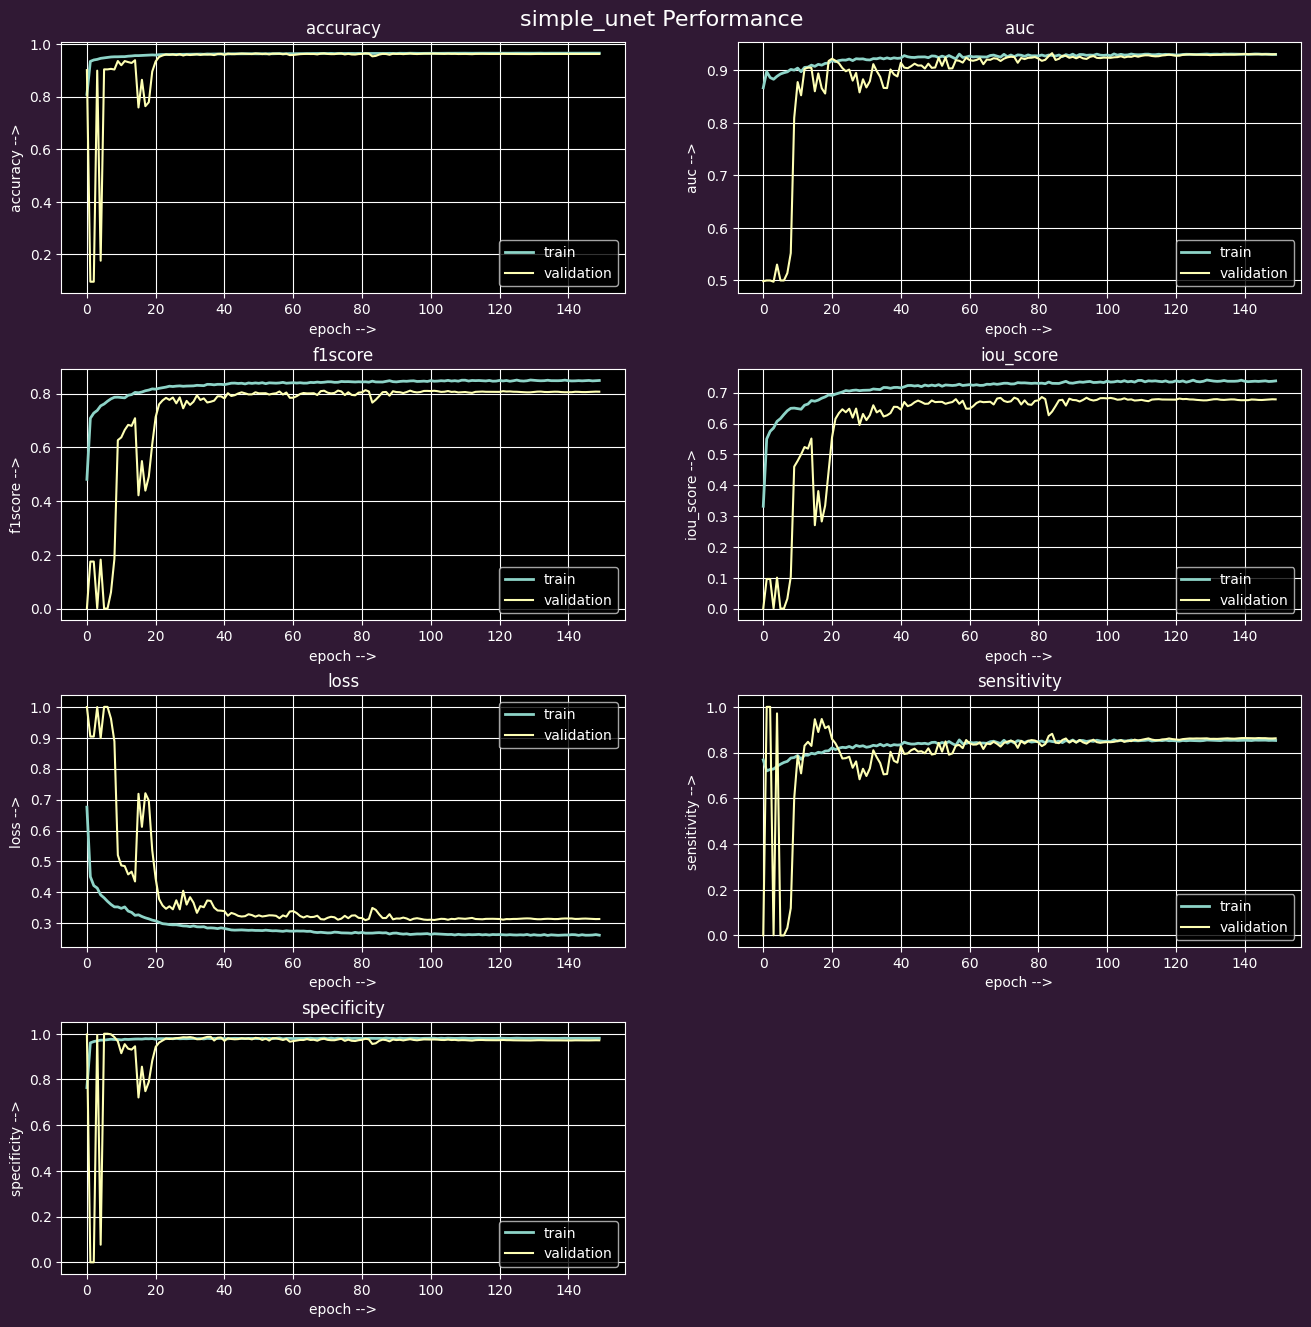

In [62]:
# model_name = "unet"
# History = History_dict[ model_name]

metric_List = list(History.keys())


plt.figure(figsize = (16,16),facecolor='#301934').suptitle(model_name+" Performance",fontsize=16, y=0.90)
for i,metric in enumerate(metric_List[:7],1):
    plt.subplot(4,2,i)
    plt.plot(History[metric],label='train',linewidth=2)
    plt.plot(History['val_'+ metric],label='validation',linewidth=1.5)
    plt.title(metric)
    plt.legend()
    plt.ylabel(metric + ' -->')
    plt.xlabel('epoch -->')
    plt.subplots_adjust(wspace=0.2, hspace=0.3) 
    plt.grid()
plt.show()

### > comparision plot

### > Sample Predictions

In [63]:
def get_pred_mask(image):
    return Model.predict(tf.expand_dims(image,axis=0),verbose=0)[0]

In [64]:
def get_aug_image(image):
    mask_pred_1 = get_pred_mask(image)
    
    mask_pred_2 = get_pred_mask(np.fliplr(image))
    mask_pred_2 = np.fliplr(mask_pred_2)
    
    mask_pred_3 = get_pred_mask(np.flipud(image))
    mask_pred_3 = np.flipud(mask_pred_3)
    
    # mask_pred_4 = get_pred_mask(np.flipud(np.fliplr(image)))
    # mask_pred_4 = np.flipud(np.fliplr(mask_pred_4))
    
    mask_pred_aug = (mask_pred_1 + mask_pred_2 + mask_pred_3 )/3
    return mask_pred_1 ,mask_pred_aug

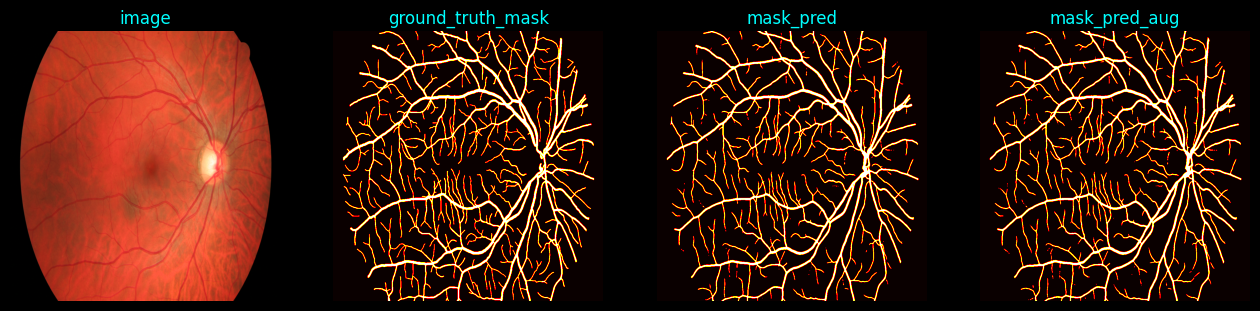

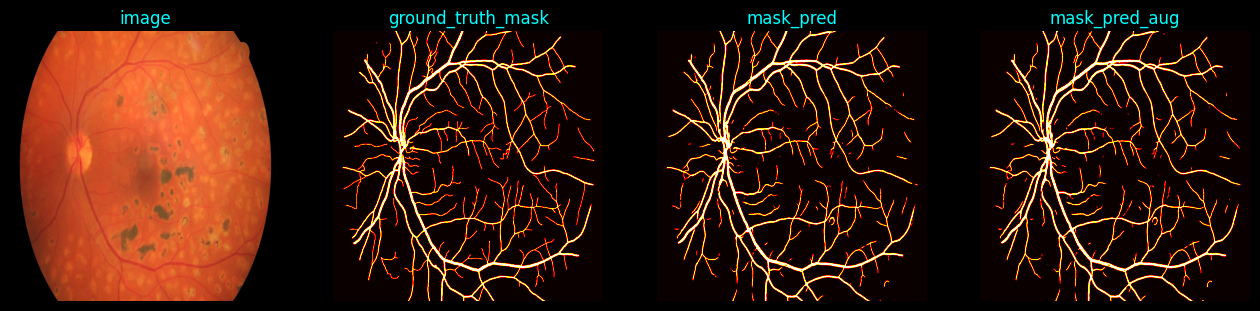

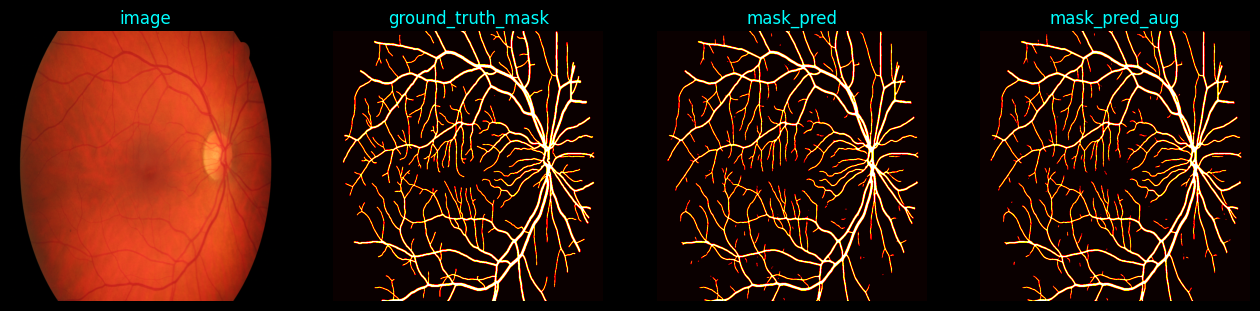

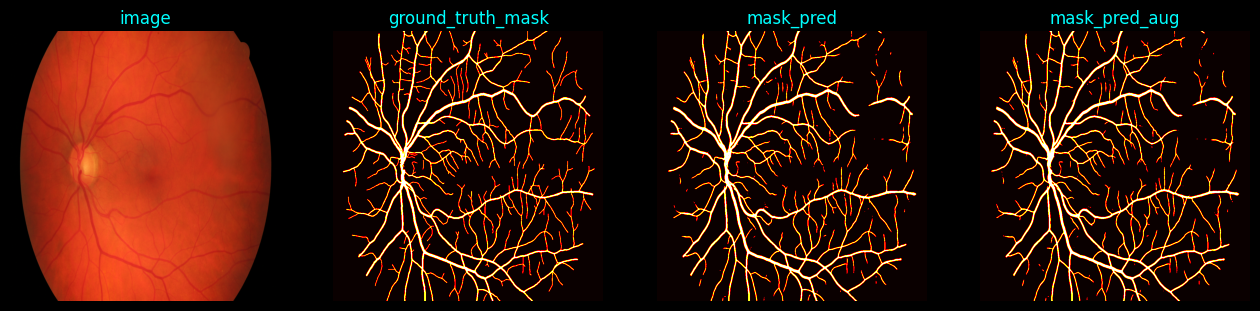

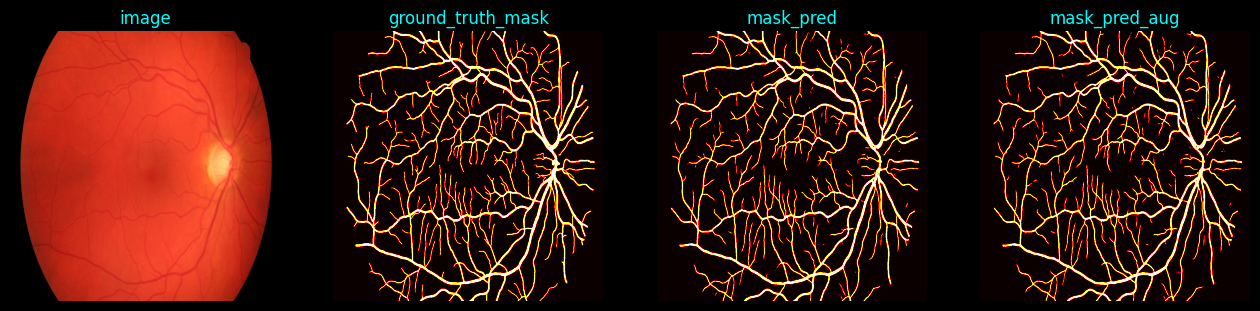

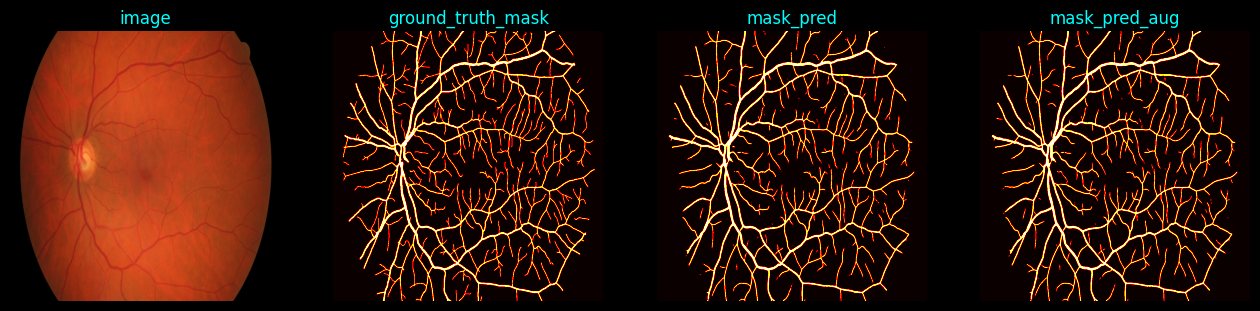

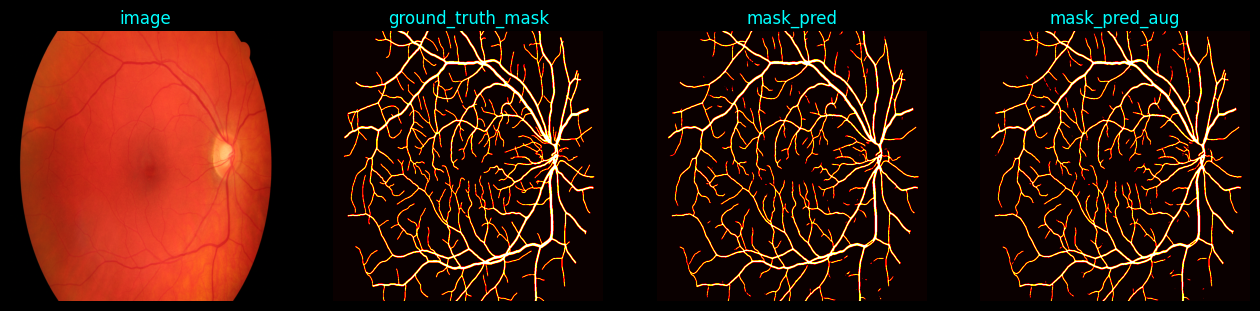

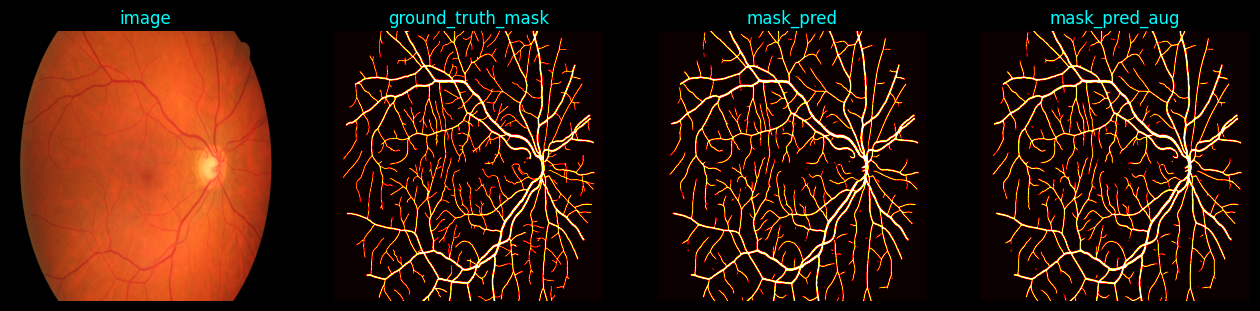

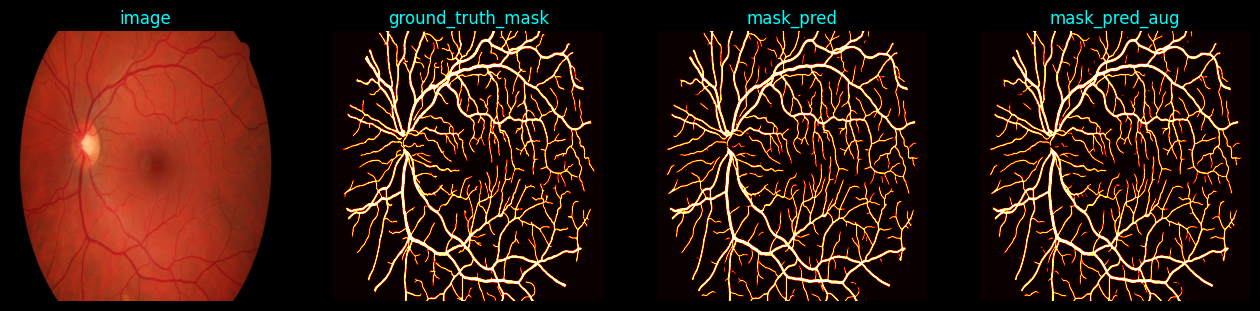

In [65]:
threshold = 0.5
for image , mask in zip(test_images , test_masks):
# for image , mask in zip(test_images , test_masks):
    
#     print(image.min() ,image.max() , mask.min() ,mask.max())
    mask_pred , mask_pred_aug = get_aug_image(image)
    
    mask_pred = (mask_pred>threshold)
    mask_pred_aug = (mask_pred_aug > threshold)
        
    image = (image-image.min()) / (image.max()-image.min()) 
    
    display_images([image[...,:3] ,mask,mask_pred,mask_pred_aug],['image','ground_truth_mask','mask_pred','mask_pred_aug'],size = 4,cmap='hot')

In [ ]:
# np.max(new_image)

In [ ]:
new_image = prev_Model(train_images[index:index+1])[0]
display_images([train_images[index][...,:3],new_image ,train_masks[index],],cmap = 'gray',size = 6,scaling='minmax',grid=(1,3))

In [ ]:
def image_gaus_edge(image,thresh1= 50 , kernel_size = 5,channel = None):
    # Convert the image to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if(np.ndim(image)==3):
        if(channel):
            gray =  image[...,channel]
        else :
            gray = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    # print(np.shape(image))
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (kernel_size , kernel_size ), 0)  # Kernel size (5, 5), sigma = 0
    # Apply edge detection using Canny
    edge = cv2.Canny(blurred, threshold1=thresh1, threshold2=100)  # Adjust thresholds as needed

    return edge

In [ ]:
min_ = np.min(new_image ,axis = (0,1))
max_ = np.max(new_image ,axis = (0,1)) 

new_image = 255*(new_image - min_) /( max_ - min_)
new_image = np.array( new_image , dtype ='uint8')

In [ ]:
img_edge_1= image_gaus_edge(new_image, 300,3,channel=1)
img_edge_2= image_gaus_edge(new_image, 100,5,channel=0)
display_images([img_edge_1,img_edge_2,new_image,train_masks[index]] ,size=5,cmap = 'gray' , grid=(3,2))

## > Saving Results

In [ ]:
# [ 'pretrained_unet' ,'residual_unet' ,'r2_unet' , 'residual_attention_aunet']

In [73]:
import json

In [ ]:
with open(base_path+'dataset/account_content','r') as file:
    content = file.read()
Folder_key_dict  = json.loads(content)
# Address_dict

In [ ]:
# pip install mediafire

In [ ]:
from mediafire import MediaFireApi
from mediafire import MediaFireUploader
api = MediaFireApi()
uploader = MediaFireUploader(api)

In [68]:
def upload_models():
    base_path = 'Models' 
    try:
        os.mkdir(base_path)
    except:
        pass
        
#     folder_key = Folder_key_dict['EyeSegmentation'][dataset_name][base_path]['folder_key']
#     print(folder_key)
    
    for model_name , model in Model_dict.items():
        model_save_path = base_path + '/' + model_name + '.keras'
        model.save(model_save_path)

#         session = api.user_get_session_token(
#                         email='prajwalsharma.bt21cse@pec.edu.in',
#                         password='Praju@321',
#                         app_id='42511',
#         )
        
#         api.session = session
    
#         try:
#             print(model_name ,'upload started >>>')
#             with open(model_save_path ,'rb') as model_file:
#                 uploader = MediaFireUploader(api)
#                 %time result = uploader.upload(model_file , model_name , folder_key=folder_key)
#             print(model_name ,'uploaded successfully')
#             print('------------------------------------------------------------------------------------')
#         except Exception as e:
#             print("Error :",e)

In [69]:
def upload_Dict(Dict , dict_name = 'history_dict'):
    base_path = 'Meta' 
    try:
        os.mkdir(base_path)
    except:
        pass
    
#     folder_key = Folder_key_dict['EyeSegmentation'][dataset_name][base_path]['folder_key']
#     print(folder_key)
    
    dict_file_name = base_path + '/' + dict_name+'.txt'
    
    dict_str = dict_str = json.dumps(Dict)
    dict_str = dict_str.encode()
    with open(dict_file_name,'wb') as dict_file :
        dict_file.write(dict_str)

#     session = api.user_get_session_token(
#                     email='prajwalsharma.bt21cse@pec.edu.in',
#                     password='Praju@321',
#                     app_id='42511',
#     )
#     api.session = session

#     try:
#         with open(dict_file_name ,'rb') as dict_file:
#             dict_str2 = dict_file.read()
#             Dict2 = json.loads(dict_str2)
            
#             uploader = MediaFireUploader(api)
#             %time result = uploader.upload(dict_file , dict_name , folder_key=folder_key) 
    
#     except Exception as e:
#         print("Error :",e)

In [71]:
# upload_models()

In [74]:
# upload_Dict(History_dict)

In [ ]:
# Model = models.load_model('Models/pretrained_unet_keras',compile=False)
# Model.evaluate(test_images,test_masks)

In [ ]:
# with open('Meta/history_dict_.txt' ,'rb') as dict_file:
#     dict_str2 = dict_file.read()
# Dict2 = json.loads(dict_str2)
# Dict2

In [ ]:
api = MediaFireApi()
# uploader = MediaFireUploader(api)

session = api.user_get_session_token(
                email='prajwalsharma.bt21cse@pec.edu.in',
                password='Praju@321',
                app_id='42511',
)